<a href="https://colab.research.google.com/github/louiezzang/nextmining-forecasting/blob/main/notebooks/temporal_fusion_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import gc
import glob
import os
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch import nn
import torchvision
import torch

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [2]:
class GLU(nn.Module):
    """
      The Gated Linear Unit GLU(a,b) = mult(a,sigmoid(b)) is common in NLP
      architectures like the Gated CNN. Here sigmoid(b) corresponds to a gate
      that controls what information from a is passed to the following layer.

      Args:
          input_size (int): number defining input and output size of the gate
    """
    def __init__(self, input_size):
        super().__init__()

        # Input
        self.a = nn.Linear(input_size, input_size)

        # Gate
        self.sigmoid = nn.Sigmoid()
        self.b = nn.Linear(input_size, input_size)

    def forward(self, x):
        """
        Args:
            x (torch.tensor): tensor passing through the gate
        """
        gate = self.sigmoid(self.b(x))
        x = self.a(x)

        return torch.mul(gate, x)

In [3]:
class TemporalLayer(nn.Module):
    def __init__(self, module):
        super().__init__()
        """
        Collapses input of dim T*N*H to (T*N)*H, and applies to a module.
        Allows handling of variable sequence lengths and minibatch sizes.

        Similar to TimeDistributed in Keras, it is a wrapper that makes it possible
        to apply a layer to every temporal slice of an input.
        """
        self.module = module


    def forward(self, x):
        """
        Args:
            x (torch.tensor): tensor with time steps to pass through the same layer.
        """
        t, n = x.size(0), x.size(1)
        x = x.reshape(t * n, -1)
        x = self.module(x)
        x = x.reshape(t, n, x.size(-1))

        return x

In [4]:
class GatedResidualNetwork(nn.Module):
    """
      The Gated Residual Network gives the model flexibility to apply non-linear
      processing only when needed. It is difficult to know beforehand which
      variables are relevant and in some cases simpler models can be beneficial.

      GRN(a, c) = LayerNorm(a + GLU(eta_1)) # Dropout is applied to eta_1
        eta_1 = W_1*eta_2 + b_1
        eta_2 = ELU(W_2*a + W_3*c + b_2)

      Args:
          input_size (int): Size of the input
          hidden_size (int): Size of the hidden layer
          output_size (int): Size of the output layer
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
          context_size (int): Size of the static context vector
          is_temporal (bool): Flag to decide if TemporalLayer has to be used or not
    """
    def __init__(self, input_size, hidden_size, output_size, dropout, context_size=None, is_temporal=True):
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.is_temporal = is_temporal

        if self.is_temporal:
            if self.input_size != self.output_size:
                self.skip_layer = TemporalLayer(nn.Linear(self.input_size, self.output_size))

            # Context vector c
            if self.context_size != None:
                self.c = TemporalLayer(nn.Linear(self.context_size, self.hidden_size, bias=False))

            # Dense & ELU
            self.dense1 = TemporalLayer(nn.Linear(self.input_size, self.hidden_size))
            self.elu = nn.ELU()

            # Dense & Dropout
            self.dense2 = TemporalLayer(nn.Linear(self.hidden_size,  self.output_size))
            self.dropout = nn.Dropout(self.dropout)

            # Gate, Add & Norm
            self.gate = TemporalLayer(GLU(self.output_size))
            self.layer_norm = TemporalLayer(nn.BatchNorm1d(self.output_size))

        else:
            if self.input_size != self.output_size:
                self.skip_layer = nn.Linear(self.input_size, self.output_size)

            # Context vector c
            if self.context_size != None:
                self.c = nn.Linear(self.context_size, self.hidden_size, bias=False)

            # Dense & ELU
            self.dense1 = nn.Linear(self.input_size, self.hidden_size)
            self.elu = nn.ELU()

            # Dense & Dropout
            self.dense2 = nn.Linear(self.hidden_size,  self.output_size)
            self.dropout = nn.Dropout(self.dropout)

            # Gate, Add & Norm
            self.gate = GLU(self.output_size)
            self.layer_norm = nn.BatchNorm1d(self.output_size)


    def forward(self, x, c=None):
        """
        Args:
            x (torch.tensor): tensor thas passes through the GRN
            c (torch.tensor): Optional static context vector
        """

        if self.input_size!=self.output_size:
            a = self.skip_layer(x)
        else:
            a = x

        x = self.dense1(x)

        if c != None:
            c = self.c(c.unsqueeze(1))
            x += c

        eta_2 = self.elu(x)

        eta_1 = self.dense2(eta_2)
        eta_1 = self.dropout(eta_1)

        gate = self.gate(eta_1)
        gate += a
        x = self.layer_norm(gate)

        return x

In [5]:
class VariableSelectionNetwork(nn.Module):
    """
      The Variable Selection Network gives the model the ability to remove
      unnecessary noisy inputs that could have a negative impact on performance.
      It also allows us to better understand which variables are most important
      for the prediction task.

      The variable selection weights are created by feeding both the flattened
      vector of all past inputs at time t (E_t) and an optional context vector
      through a GRN, followed by a Softmax layer.

      V_xt = Softmax(GRN_v(E_t, c_s))

      Also, the feature vector for each variable is fed through its
      own GRN to create an additional layer of non-linear processing.

      Processed features are then weighted by the variable selection weights
      and combined.

      Args:
          input_size (int): Size of the input
          output_size (int): Size of the output layer
          hidden_size (int): Size of the hidden layer
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
          context_size (int): Size of the static context vector
          is_temporal (bool): Flag to decide if TemporalLayer has to be used or not
    """
    def __init__(self, input_size, output_size, hidden_size, dropout, context_size=None, is_temporal=True):
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        self.dropout = dropout
        self.context_size = context_size
        self.is_temporal = is_temporal

        self.flattened_inputs = GatedResidualNetwork(self.output_size*self.input_size,
                                                     self.hidden_size, self.output_size,
                                                     self.dropout, self.context_size,
                                                     self.is_temporal)

        self.transformed_inputs = nn.ModuleList(
            [GatedResidualNetwork(
                self.input_size, self.hidden_size, self.hidden_size,
                self.dropout, self.context_size, self.is_temporal) for i in range(self.output_size)])

        self.softmax = nn.Softmax(dim=-1)


    def forward(self, embedding, context=None):
        """
        Args:
          embedding (torch.tensor): Entity embeddings for categorical variables and linear
                     transformations for continuous variables.
          context (torch.tensor): The context is obtained from a static covariate encoder and
                   is naturally omitted for static variables as they already
                   have access to this
        """

        # Generation of variable selection weights
        sparse_weights = self.flattened_inputs(embedding, context)
        if self.is_temporal:
            sparse_weights = self.softmax(sparse_weights).unsqueeze(2)
        else:
            sparse_weights = self.softmax(sparse_weights).unsqueeze(1)

        # Additional non-linear processing for each feature vector
        transformed_embeddings = torch.stack(
            [self.transformed_inputs[i](embedding[
                Ellipsis, i*self.input_size:(i+1)*self.input_size]) for i in range(self.output_size)], axis=-1)

        # Processed features are weighted by their corresponding weights and combined
        combined = transformed_embeddings*sparse_weights
        combined = combined.sum(axis=-1)

        return combined, sparse_weights

In [6]:
class ScaledDotProductAttention(nn.Module):
    """
    Attention mechansims usually scale values based on relationships between
    keys and queries.

    Attention(Q,K,V) = A(Q,K)*V where A() is a normalization function.

    A common choice for the normalization function is scaled dot-product attention:

    A(Q,K) = Softmax(Q*K^T / sqrt(d_attention))

    Args:
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
    """
    def __init__(self, dropout=0.0):
        super().__init__()

        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=2)


    def forward(self, query, key, value, mask=None):
        """
        Args:
          query (torch.tensor):
          key (torch.tensor):
          value (torch.tensor):
          mask (torch.tensor):
        """

        d_k = key.shape[-1]
        scaling_factor = torch.sqrt(torch.tensor(d_k).to(torch.float32))

        scaled_dot_product = torch.matmul(query, key.permute(0,2,1)) / scaling_factor
        if mask != None:
            scaled_dot_product = scaled_dot_product.masked_fill(mask == 0, -1e9)
        attention = self.softmax(scaled_dot_product)
        attention = self.dropout(attention)
        output = torch.matmul(attention, value)

        return output, attention

In [7]:
class InterpretableMultiHeadAttention(nn.Module):
    """
    Different attention heads can be used to improve the learning capacity of
    the model.

    MultiHead(Q,K,V) = [H_1, ..., H_m]*W_H
    H_h = Attention(Q*Wh_Q, K*Wh_K, V*Wh_V)

    Each head has specific weights for keys, queries and values. W_H linearly
    combines the concatenated outputs from all heads.

    To increase interpretability, multi-head attention has been modified to share
    values in each head.

    InterpretableMultiHead(Q,K,V) = H_I*W_H
    H_I = 1/H * SUM(Attention(Q*Wh_Q, K*Wh_K, V*W_V)) # Note that W_V does not depend on the head.

    Args:
          num_heads (int): Number of attention heads
          hidden_size (int): Hidden size of the model
          dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
    """
    def __init__(self, num_attention_heads, hidden_size, dropout=0.0):
        super().__init__()

        self.num_attention_heads = num_attention_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)

        self.qs = nn.ModuleList([nn.Linear(self.hidden_size, self.hidden_size, bias=False) for i in range(self.num_attention_heads)])
        self.ks = nn.ModuleList([nn.Linear(self.hidden_size, self.hidden_size, bias=False) for i in range(self.num_attention_heads)])

        vs_layer = nn.Linear(self.hidden_size, self.hidden_size, bias=False) # Value is shared for improved interpretability
        self.vs = nn.ModuleList([vs_layer for i in range(self.num_attention_heads)])

        self.attention = ScaledDotProductAttention()
        self.linear = nn.Linear(self.hidden_size, self.hidden_size, bias=False)


    def forward(self, query, key, value, mask=None):

        batch_size, tgt_len, embed_dim = query.shape
        head_dim = embed_dim // self.num_attention_heads

        # Now we iterate over each head to calculate outputs and attention
        heads = []
        attentions = []

        for i in range(self.num_attention_heads):
            q_i = self.qs[i](query)
            k_i = self.ks[i](key)
            v_i = self.vs[i](value)

            # Reshape q, k, v for multihead attention
            q_i = query.reshape(batch_size, tgt_len, self.num_attention_heads, head_dim).transpose(1,2).reshape(batch_size*self.num_attention_heads, tgt_len, head_dim)
            k_i = key.reshape(batch_size, tgt_len, self.num_attention_heads, head_dim).transpose(1,2).reshape(batch_size*self.num_attention_heads, tgt_len, head_dim)
            v_i = value.reshape(batch_size, tgt_len, self.num_attention_heads, head_dim).transpose(1,2).reshape(batch_size*self.num_attention_heads, tgt_len, head_dim)

            head, attention = self.attention(q_i, k_i, v_i, mask)

            # Revert to original target shape
            head = head.reshape(batch_size, self.num_attention_heads, tgt_len, head_dim).transpose(1,2).reshape(-1, tgt_len, self.num_attention_heads*head_dim)
            head_dropout = self.dropout(head)
            heads.append(head_dropout)
            attentions.append(attention)

        # Output the results
        if self.num_attention_heads > 1:
            heads = torch.stack(heads, dim=2) #.reshape(batch_size, tgt_len, -1, self.hidden_size)
            outputs = torch.mean(heads, dim=2)
        else:
            outputs = head

        attentions = torch.stack(attentions, dim=2)
        attention = torch.mean(attentions, dim=2)

        outputs = self.linear(outputs)
        outputs = self.dropout(outputs)

        return outputs, attention

In [8]:
class QuantileLoss(nn.Module):
    """
    Implementation source: https://medium.com/the-artificial-impostor/quantile-regression-part-2-6fdbc26b2629

    Args:
          quantiles (list): List of quantiles that will be used for prediction
    """

    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles

    def forward(self, preds, target):
        """
        Args:
              preds (torch.tensor): Model predictions
              target (torch.tensor): Target data
        """
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)

        losses = []
        for i, q in enumerate(self.quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))

        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))

        return loss

In [9]:
class TemporalFusionTransformer(nn.Module):
    """Creates a Temporal Fusion Transformer model.

    For simplicity, arguments are passed within a parameters dictionary

    Args:
        col_to_idx (dict): Maps column names to their index in input array
        static_covariates (list): Names of static covariate variables
        time_dependent_categorical (list): Names of time dependent categorical variables
        time_dependent_continuous (list): Names of time dependent continuous variables
        category_counts (dict): Maps column names to the number of categories of each categorical feature
        known_time_dependent (list): Names of known time dependent variables
        observed_time_dependent (list): Names of observed time dependent variables
        batch_size (int): Batch size
        encoder_steps (int): Fixed k time steps to look back for each prediction (also size of LSTM encoder)
        hidden_size (int): Internal state size of different layers
        num_lstm_layers (int): Number of LSTM layers that should be used
        dropout (float): Fraction between 0 and 1 corresponding to the degree of dropout used
        embedding_dim (int): Dimensionality of embeddings
        num_attention_heads (int): Number of heads for interpretable mulit-head attention
        quantiles (list): Quantiles used for prediction. Also defines model output size
        device (str): Used to decide between CPU and GPU

    """
    def __init__(self, parameters):
        """Uses the given parameters to set up the Temporal Fusion Transformer model

        Args:
          parameters: Dictionary with parameters used to define the model.
        """
        super().__init__()

        # Inputs
        self.col_to_idx = parameters["col_to_idx"]
        self.static_covariates = parameters["static_covariates"]
        self.time_dependent_categorical = parameters["time_dependent_categorical"]
        self.time_dependent_continuous = parameters["time_dependent_continuous"]
        self.category_counts = parameters["category_counts"]
        self.known_time_dependent = parameters["known_time_dependent"]
        self.observed_time_dependent = parameters["observed_time_dependent"]
        self.time_dependent = self.known_time_dependent+self.observed_time_dependent

        # Architecture
        self.batch_size = parameters['batch_size']
        self.encoder_steps = parameters['encoder_steps']
        self.hidden_size = parameters['hidden_layer_size']
        self.num_lstm_layers = parameters['num_lstm_layers']
        self.dropout = parameters['dropout']
        self.embedding_dim = parameters['embedding_dim']
        self.num_attention_heads = parameters['num_attention_heads']

        # Outputs
        self.quantiles = parameters['quantiles']

        # Other
        self.device = parameters['device']


        # Prepare for input transformation (embeddings for categorical variables and linear transformations for continuous variables)

        # Prepare embeddings for the static covariates and static context vectors
        self.static_embeddings = nn.ModuleDict({col: nn.Embedding(self.category_counts[col], self.embedding_dim).to(self.device) for col in self.static_covariates})
        self.static_variable_selection = VariableSelectionNetwork(self.embedding_dim, len(self.static_covariates), self.hidden_size, self.dropout, is_temporal=False)

        self.static_context_variable_selection = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, is_temporal=False)
        self.static_context_enrichment = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, is_temporal=False)
        self.static_context_state_h = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, is_temporal=False)
        self.static_context_state_c = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, is_temporal=False)

        # Prepare embeddings and linear transformations for time dependent variables
        self.temporal_cat_embeddings = nn.ModuleDict({col: TemporalLayer(nn.Embedding(self.category_counts[col], self.embedding_dim)).to(self.device) for col in self.time_dependent_categorical})
        self.temporal_real_transformations = nn.ModuleDict({col: TemporalLayer(nn.Linear(1, self.embedding_dim)).to(self.device) for col in self.time_dependent_continuous})

        # Variable selection and encoder for past inputs
        self.past_variable_selection = VariableSelectionNetwork(self.embedding_dim, len(self.time_dependent), self.hidden_size, self.dropout, context_size=self.hidden_size)

        # Variable selection and decoder for known future inputs
        self.future_variable_selection = VariableSelectionNetwork(self.embedding_dim, len([col for col in self.time_dependent if col not in self.observed_time_dependent]),
                                                                  self.hidden_size, self.dropout, context_size=self.hidden_size)

        # LSTM encoder and decoder
        self.lstm_encoder = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=self.num_lstm_layers, dropout=self.dropout)
        self.lstm_decoder = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=self.num_lstm_layers, dropout=self.dropout)

        # Gated skip connection and normalization
        self.gated_skip_connection = TemporalLayer(GLU(self.hidden_size))
        self.add_norm = TemporalLayer(nn.BatchNorm1d(self.hidden_size))

        # Temporal Fusion Decoder

        # Static enrichment layer
        self.static_enrichment = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout, self.hidden_size)

        # Temporal Self-attention layer
        self.multihead_attn = InterpretableMultiHeadAttention(self.num_attention_heads, self.hidden_size)
        self.attention_gated_skip_connection = TemporalLayer(GLU(self.hidden_size))
        self.attention_add_norm = TemporalLayer(nn.BatchNorm1d(self.hidden_size, self.hidden_size))

        # Position-wise feed-forward layer
        self.position_wise_feed_forward = GatedResidualNetwork(self.hidden_size, self.hidden_size, self.hidden_size, self.dropout)

        # Output layer
        self.output_gated_skip_connection = TemporalLayer(GLU(self.hidden_size))
        self.output_add_norm = TemporalLayer(nn.BatchNorm1d(self.hidden_size, self.hidden_size))

        self.output = TemporalLayer(nn.Linear(self.hidden_size, len(self.quantiles)))



    def define_static_covariate_encoders(self, x):
        embedding_vectors = [self.static_embeddings[col](x[:, 0, self.col_to_idx[col]].long().to(self.device)) for col in self.static_covariates]
        static_embedding = torch.cat(embedding_vectors, dim=1)
        static_encoder, static_weights = self.static_variable_selection(static_embedding)

        # Static context vectors
        static_context_s = self.static_context_variable_selection(static_encoder) # Context for temporal variable selection
        static_context_e = self.static_context_enrichment(static_encoder) # Context for static enrichment layer
        static_context_h = self.static_context_state_h(static_encoder) # Context for local processing of temporal features (encoder/decoder)
        static_context_c = self.static_context_state_c(static_encoder) # Context for local processing of temporal features (encoder/decoder)

        return static_encoder, static_weights, static_context_s, static_context_e, static_context_h, static_context_c


    def define_past_inputs_encoder(self, x, context):
        embedding_vectors = torch.cat([self.temporal_cat_embeddings[col](x[:, :, self.col_to_idx[col]].long()) for col in self.time_dependent_categorical], dim=2)
        transformation_vectors = torch.cat([self.temporal_real_transformations[col](x[:, :, self.col_to_idx[col]]) for col in self.time_dependent_continuous], dim=2)

        past_inputs = torch.cat([embedding_vectors, transformation_vectors], dim=2)
        past_encoder, past_weights = self.past_variable_selection(past_inputs, context)

        return past_encoder.transpose(0, 1), past_weights


    def define_known_future_inputs_decoder(self, x, context):
        embedding_vectors = torch.cat([self.temporal_cat_embeddings[col](x[:, :, self.col_to_idx[col]].long()) for col in self.time_dependent_categorical if col not in self.observed_time_dependent], dim=2)

        transformation_vectors = torch.cat([self.temporal_real_transformations[col](x[:, :, self.col_to_idx[col]]) for col in self.time_dependent_continuous if col not in self.observed_time_dependent], dim=2)

        future_inputs = torch.cat([embedding_vectors, transformation_vectors], dim=2)
        future_decoder, future_weights = self.future_variable_selection(future_inputs, context)

        return future_decoder.transpose(0, 1), future_weights


    def define_lstm_encoder(self, x, static_context_h, static_context_c):
        output, (state_h, state_c) = self.lstm_encoder(x, (static_context_h.unsqueeze(0).repeat(self.num_lstm_layers,1,1),
                                                           static_context_c.unsqueeze(0).repeat(self.num_lstm_layers,1,1)))

        return output, state_h, state_c


    def define_lstm_decoder(self, x, state_h, state_c):
        output, (_, _) = self.lstm_decoder(x, (state_h.unsqueeze(0).repeat(self.num_lstm_layers,1,1),
                                               state_c.unsqueeze(0).repeat(self.num_lstm_layers,1,1)))

        return output


    def get_mask(self, attention_inputs):
        #mask = torch.cumsum(torch.eye(attention_inputs.shape[1]*self.num_attention_heads, attention_inputs.shape[0]), dim=1)
        mask = torch.cumsum(torch.eye(attention_inputs.shape[0]*self.num_attention_heads, attention_inputs.shape[1]), dim=1)

        return mask.unsqueeze(2).to(self.device)


    def forward(self, x):

        # Static variable selection and static covariate encoders
        static_encoder, static_weights, static_context_s, static_context_e, static_context_h, static_context_c = self.define_static_covariate_encoders(x["inputs"])

        # Past input variable selection and LSTM encoder
        past_encoder, past_weights = self.define_past_inputs_encoder(x["inputs"][:, :self.encoder_steps, :].float().to(self.device), static_context_s)

        # Known future inputs variable selection and LSTM decoder
        future_decoder, future_weights = self.define_known_future_inputs_decoder(x["inputs"][:, self.encoder_steps:, :].float().to(self.device), static_context_s)


        # Pass output from variable selection through LSTM encoder and decoder
        encoder_output, state_h, state_c = self.define_lstm_encoder(past_encoder, static_context_h, static_context_c)
        decoder_output = self.define_lstm_decoder(future_decoder, static_context_h, static_context_c)

        # Gated skip connection before moving into the Temporal Fusion Decoder
        variable_selection_outputs = torch.cat([past_encoder, future_decoder], dim=0)
        lstm_outputs = torch.cat([encoder_output, decoder_output], dim=0)
        gated_outputs = self.gated_skip_connection(lstm_outputs)
        temporal_feature_outputs = self.add_norm(variable_selection_outputs.add(gated_outputs))
        temporal_feature_outputs = temporal_feature_outputs.transpose(0, 1)

        # Temporal Fusion Decoder

        # Static enrcihment layer
        static_enrichment_outputs = self.static_enrichment(temporal_feature_outputs, static_context_e)

        # Temporal Self-attention layer
        mask = self.get_mask(static_enrichment_outputs)
        multihead_outputs, multihead_attention = self.multihead_attn(static_enrichment_outputs, static_enrichment_outputs, static_enrichment_outputs, mask=mask)

        attention_gated_outputs = self.attention_gated_skip_connection(multihead_outputs)
        attention_outputs = self.attention_add_norm(attention_gated_outputs.add(static_enrichment_outputs))

        # Position-wise feed-forward layer
        temporal_fusion_decoder_outputs = self.position_wise_feed_forward(attention_outputs)

        # Output layer
        gate_outputs = self.output_gated_skip_connection(temporal_fusion_decoder_outputs)
        norm_outputs = self.output_add_norm(gate_outputs.add(temporal_feature_outputs))

        output = self.output(norm_outputs[:, self.encoder_steps:, :]).view(-1,3)

        attention_weights = {
            'multihead_attention': multihead_attention,
            'static_weights': static_weights[Ellipsis, 0],
            'past_weights': past_weights[Ellipsis, 0, :],
            'future_weights': future_weights[Ellipsis, 0, :]
        }

        return  output, attention_weights

In [10]:
class TFT_Dataset(Dataset):
    def __init__(self, data, entity_column, time_column, target_column,
                 input_columns, encoder_steps, decoder_steps):
        """
          data (pd.DataFrame): dataframe containing raw data
          entity_column (str): name of column containing entity data
          time_column (str): name of column containing date data
          target_column (str): name of column we need to predict
          input_columns (list): list of string names of columns used as input
          encoder_steps (int): number of known past time steps used for forecast. Equivalent to size of LSTM encoder
          decoder_steps (int): number of input time steps used for each forecast date. Equivalent to the width N of the decoder
        """

        self.encoder_steps = encoder_steps

        inputs = []
        outputs = []
        entity = []
        time = []

        for e in train[entity_column].unique():
          entity_group = data[data[entity_column]==e]

          data_time_steps = len(entity_group)

          if data_time_steps >= decoder_steps:
            x = entity_group[input_columns].values.astype(np.float32)
            inputs.append(np.stack([x[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

            y = entity_group[[target_column]].values.astype(np.float32)
            outputs.append(np.stack([y[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

            e = entity_group[[entity_column]].values.astype(np.float32)
            entity.append(np.stack([e[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

            t = entity_group[[time_column]].values.astype(np.int64)
            time.append(np.stack([t[i:data_time_steps - (decoder_steps - 1) + i, :] for i in range(decoder_steps)], axis=1))

        self.inputs = np.concatenate(inputs, axis=0)
        self.outputs = np.concatenate(outputs, axis=0)[:, encoder_steps:, :]
        self.entity = np.concatenate(entity, axis=0)
        self.time = np.concatenate(time, axis=0)
        self.active_inputs = np.ones_like(outputs)

        self.sampled_data = {
            'inputs': self.inputs,
            'outputs': self.outputs[:, self.encoder_steps:, :],
            'active_entries': np.ones_like(self.outputs[:, self.encoder_steps:, :]),
            'time': self.time,
            'identifier': self.entity
        }

    def __getitem__(self, index):
        s = {
        'inputs': self.inputs[index],
        'outputs': self.outputs[index],
        'active_entries': np.ones_like(self.outputs[index]),
        'time': self.time[index],
        'identifier': self.entity[index]
        }

        return s

    def __len__(self):
        return self.inputs.shape[0]

In [11]:
def fit_preprocessing(train, real_columns, categorical_columns):
    real_scalers = StandardScaler().fit(train[real_columns].values)

    categorical_scalers = {}
    num_classes = []
    for col in categorical_columns:
        srs = train[col].apply(str)
        categorical_scalers[col] = LabelEncoder().fit(srs.values)
        num_classes.append(srs.nunique())

    return real_scalers, categorical_scalers


def transform_inputs(df, real_scalers, categorical_scalers, real_columns, categorical_columns):
    out = df.copy()
    out[real_columns] = real_scalers.transform(df[real_columns].values)

    for col in categorical_columns:
        string_df = df[col].apply(str)
        out[col] = categorical_scalers[col].transform(string_df)

    return out

In [12]:
class WebTrafficGenerator:
    def __init__(self, start_date='2021-01-01', end_date='2024-12-31', trend_base=0.5,
                 weekly_seasonality=None, yearly_seasonality=None, noise_multiplier=10):
        self.dates = dates = pd.date_range(start=start_date, end=end_date, freq='D')
        self.trend_base = trend_base
        self.weekly_seasonality = weekly_seasonality
        self.yearly_seasonality = yearly_seasonality
        self.noise_multiplier = noise_multiplier
        self.web_traffic = []

    def generate_data(self):

        day = 24 * 60 * 60
        week = day * 7
        year = 365.2425 * day

        if self.yearly_seasonality:
            yearly = ((1 + np.sin(self.dates.view('int64') // 1e9 * \
                                  (self.yearly_seasonality * np.pi / year))) * 100).astype(int)
        else:
            yearly = 0

        if self.weekly_seasonality:
            weekly = ((1 + np.sin(self.dates.view('int64') // 1e9 * \
                                  (self.weekly_seasonality * np.pi / week))) * 10).astype(int)
        else:
            weekly = 0

        trend = np.array(range(len(self.dates)))*self.trend_base
        noise = ((np.random.random(len(self.dates))-0.5)*self.noise_multiplier).astype(int)

        return trend+yearly+weekly+noise


(array([18628., 18809., 18993., 19174., 19358., 19539., 19723., 19905.,
        20089.]),
 [Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07'),
  Text(19723.0, 0, '2024-01'),
  Text(19905.0, 0, '2024-07'),
  Text(20089.0, 0, '2025-01')])

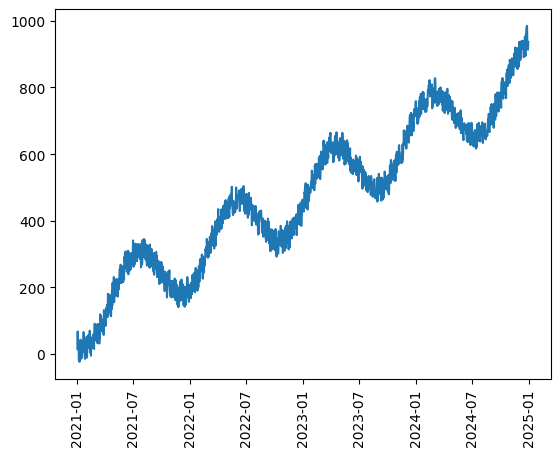

In [13]:
traffic_generator = WebTrafficGenerator(start_date='2021-01-01',
                                        end_date='2024-12-31',
                                        trend_base=0.5,
                                        weekly_seasonality=0.7,
                                        yearly_seasonality=2.3,
                                        noise_multiplier=80)
traffic = traffic_generator.generate_data()

plt.plot(traffic_generator.dates, traffic)
plt.xticks(rotation=90)

In [14]:
entities = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P"]
groups = {"High": ["A", "B", "C", "D", "E"], "Medium": ["F", "G", "H", "I", "J", "K"], "Low": ["L", "M", "N", "O", "P"]}

In [15]:
raw = pd.DataFrame(columns=['date', 'traffic', 'Entity', 'Class', 'DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'Month', 'Year'])

for e in entities:
    trend_base = np.round(np.random.random(), 2)

    if e in groups["High"]:
        trend_base *= 1.5
        group = "High"
    elif e in groups["Low"]:
        trend_base *= 0.7
        group = "Low"
    else:
        group = "Medium"

    traffic_generator = WebTrafficGenerator(start_date='2020-01-01',
                                            end_date='2024-12-31',
                                            trend_base=trend_base,
                                            weekly_seasonality=0.7 +np.round(np.random.uniform(0, 2.0), 2),
                                            yearly_seasonality=6.0 +np.round(np.random.uniform(0, 2.0), 2),
                                            noise_multiplier=80)

    traffic = traffic_generator.generate_data()
    tmp = pd.DataFrame(data={"date": traffic_generator.dates, "traffic":traffic})
    tmp["Entity"] = [e]*tmp.shape[0]
    tmp["Class"] = [group]*tmp.shape[0]
    tmp["DayOfWeek"] = tmp.date.dt.dayofweek
    tmp["DayOfMonth"] = tmp.date.dt.day
    tmp["WeekOfYear"] = tmp.date.dt.isocalendar().week
    tmp["Month"] = tmp.date.dt.month
    tmp["Year"] = tmp.date.dt.year
    tmp["DaysFromStart"] = np.arange(tmp.shape[0])
    tmp["Delta"] = tmp["traffic"].diff().fillna(0)

    raw = pd.concat([raw, tmp])

raw.reset_index(inplace=True)

(array([17897., 18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(17897.0, 0, '2019'),
  Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

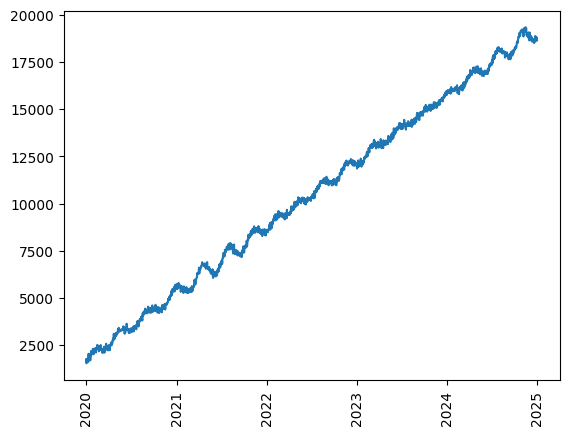

In [16]:
total = raw.groupby("date")["traffic"].sum()
plt.plot(total.index, total)
plt.xticks(rotation=90)

In [17]:
train = raw[raw['date'] < '2023-01-01']
valid = raw.loc[(raw['date'] >= '2023-01-01') & (raw['date'] < '2024-01-01')]
test = raw.loc[(raw['date'] > '2024-01-01')]

In [18]:
real_columns = ['traffic', "Delta", 'DaysFromStart']
categorical_columns = ['Entity', 'DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'Month', 'Class']

real_scalers, categorical_scalers = fit_preprocessing(train, real_columns, categorical_columns)

train = transform_inputs(train, real_scalers, categorical_scalers, real_columns, categorical_columns)
# valid = transform_inputs(valid, real_scalers, categorical_scalers, real_columns, categorical_columns)
test = transform_inputs(test, real_scalers, categorical_scalers, real_columns, categorical_columns)

In [19]:
# Global variables

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 2
DROPOUT = 0.3
LEARNING_RATE = 0.001
ENCODER_STEPS = 175
DECODER_STEPS = ENCODER_STEPS + 5
HIDDEN_LAYER_SIZE = 80
EMBEDDING_DIMENSION = 8
NUM_LSTM_LAYERS = 1
NUM_ATTENTION_HEADS = 2
QUANTILES = [0.1, 0.5, 0.9]


# Dataset variables
input_columns = ["traffic", "Delta", 'DaysFromStart', 'DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'Month', 'Entity', 'Class', 'Entity']
target_column = "traffic"
entity_column = "Entity"
time_column = "date"
col_to_idx = {col: idx for idx, col in enumerate(input_columns)}

In [20]:
params = {
    "quantiles": QUANTILES,
    "batch_size": BATCH_SIZE,
    "dropout": DROPOUT,
    "device": DEVICE,
    "hidden_layer_size": HIDDEN_LAYER_SIZE,
    "num_lstm_layers": NUM_LSTM_LAYERS,
    "embedding_dim": EMBEDDING_DIMENSION,
    "encoder_steps": ENCODER_STEPS,
    "num_attention_heads": NUM_ATTENTION_HEADS,
    "col_to_idx": col_to_idx,
    "static_covariates": ['Class', 'Entity'],
    "time_dependent_categorical": ['DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'Month'],
    "time_dependent_continuous": ['traffic', 'DaysFromStart', "Delta"],
    "category_counts": {"DayOfWeek": 7, "DayOfMonth": 31, "WeekOfYear": 53, "Month": 12, "Class": 3, "Entity": 16},
    "known_time_dependent": ['DayOfWeek', 'DayOfMonth', 'WeekOfYear', 'Month', 'DaysFromStart'],
    "observed_time_dependent": ["traffic", "Delta"]
}

In [21]:
training_data = TFT_Dataset(train, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
#validation_data = TFT_Dataset(valid, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
testing_data = TFT_Dataset(test, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
# valid_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

In [22]:
model = TemporalFusionTransformer(params)
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


TemporalFusionTransformer(
  (static_embeddings): ModuleDict(
    (Class): Embedding(3, 8)
    (Entity): Embedding(16, 8)
  )
  (static_variable_selection): VariableSelectionNetwork(
    (flattened_inputs): GatedResidualNetwork(
      (skip_layer): Linear(in_features=16, out_features=2, bias=True)
      (dense1): Linear(in_features=16, out_features=80, bias=True)
      (elu): ELU(alpha=1.0)
      (dense2): Linear(in_features=80, out_features=2, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (gate): GLU(
        (a): Linear(in_features=2, out_features=2, bias=True)
        (sigmoid): Sigmoid()
        (b): Linear(in_features=2, out_features=2, bias=True)
      )
      (layer_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (transformed_inputs): ModuleList(
      (0-1): 2 x GatedResidualNetwork(
        (skip_layer): Linear(in_features=8, out_features=80, bias=True)
        (dense1): Linear(in_features=8, out_features=80, bi

In [23]:
criterion = QuantileLoss(QUANTILES)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print_every_k = 100
losses = []

for epoch in range(NUM_EPOCHS):
    t0 = time.time()
    print(f"===== Epoch {epoch+1} =========")
    epoch_loss = 0.0
    running_loss = 0.0

    for i, batch in enumerate(train_dataloader):
        labels = batch['outputs'][:,:,0].flatten().float().to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs, attention_weights = model(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        epoch_loss += loss.item()

        if (i+1) % print_every_k == 0:
            print(f"Mini-batch {i+1} average loss: {round(running_loss / print_every_k, 5)}")
            running_loss = 0.0

    t1 = time.time()
    print(f"\nEpoch trained for {round(t1-t0, 2)} seconds")
    print("\nEpoch loss:", round(epoch_loss / (i+1), 5), "\n")
    losses.append(epoch_loss / (i+1))

===== Epoch 1 =========


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Mini-batch 100 average loss: 0.64282
Mini-batch 200 average loss: 1.1769
Mini-batch 300 average loss: 0.62881
Mini-batch 400 average loss: 0.64814


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Epoch trained for 43.54 seconds

Epoch loss: 0.73188 

===== Epoch 2 =========
Mini-batch 100 average loss: 0.55203
Mini-batch 200 average loss: 0.60994
Mini-batch 300 average loss: 0.45738
Mini-batch 400 average loss: 0.40322

Epoch trained for 41.35 seconds

Epoch loss: 0.48118 



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Plotting interpreation plots for a batch of entity 0:


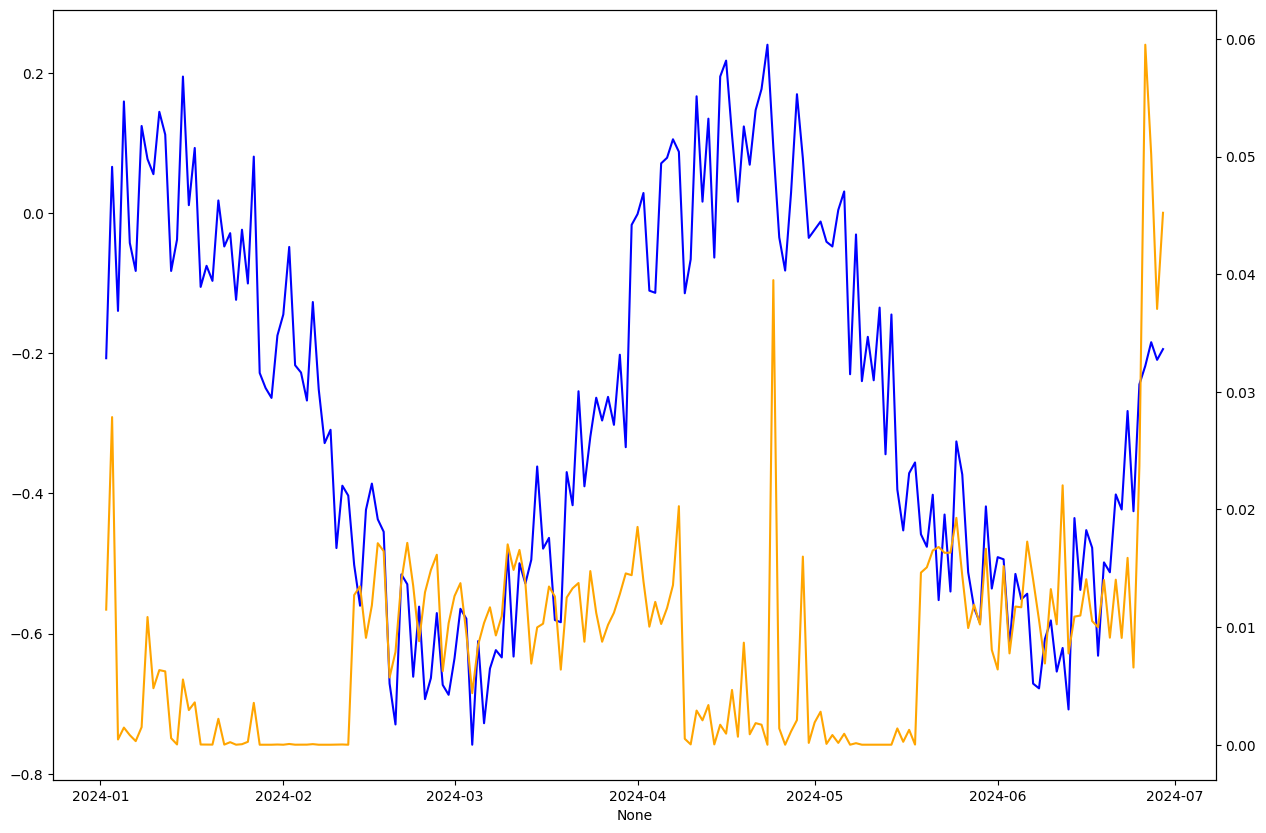

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


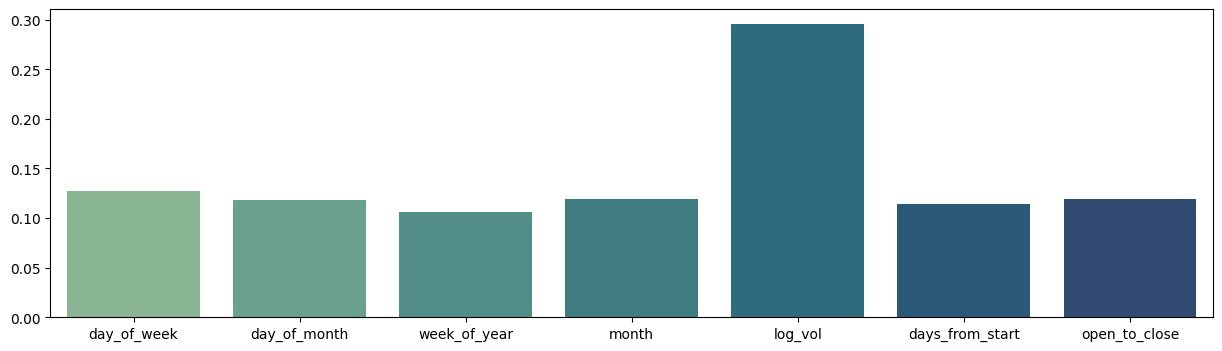

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


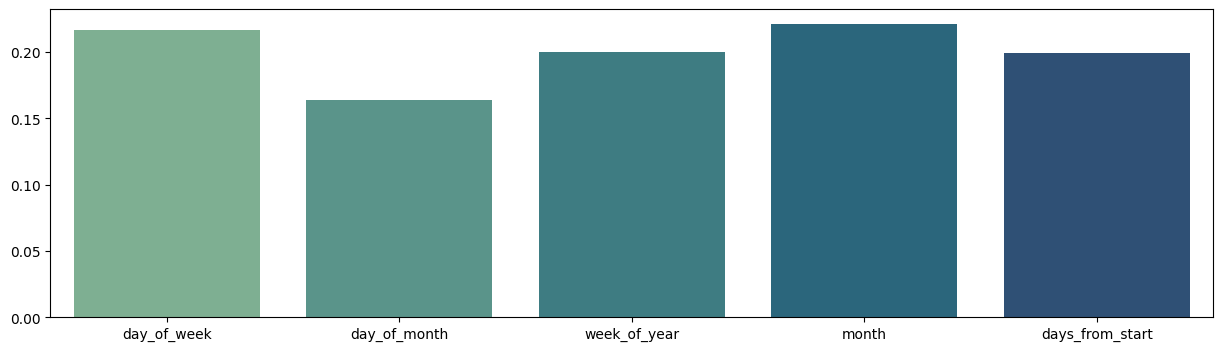


Plotting interpreation plots for a batch of entity 1:


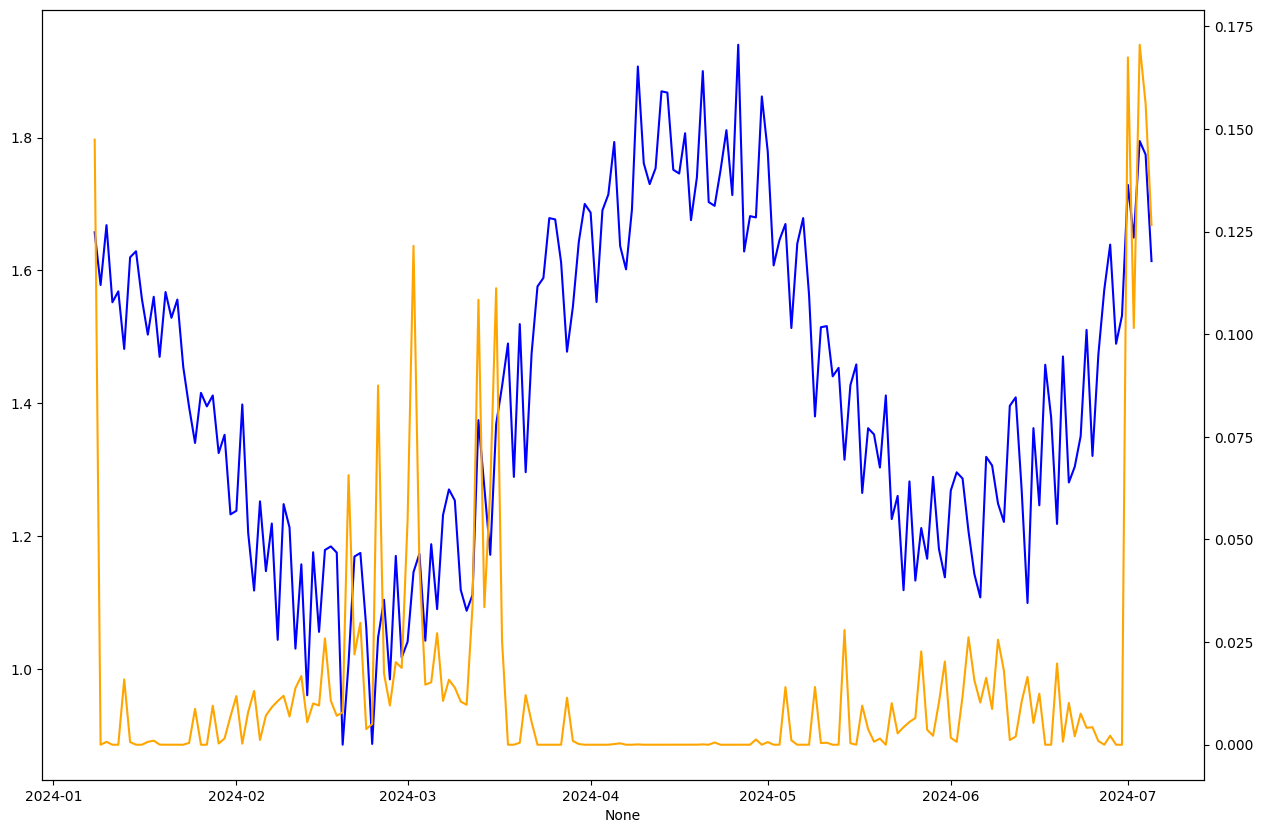

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


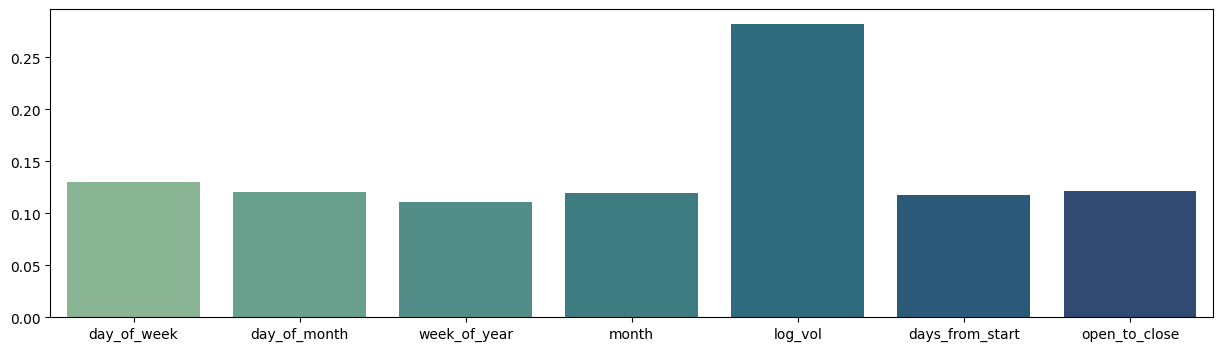

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


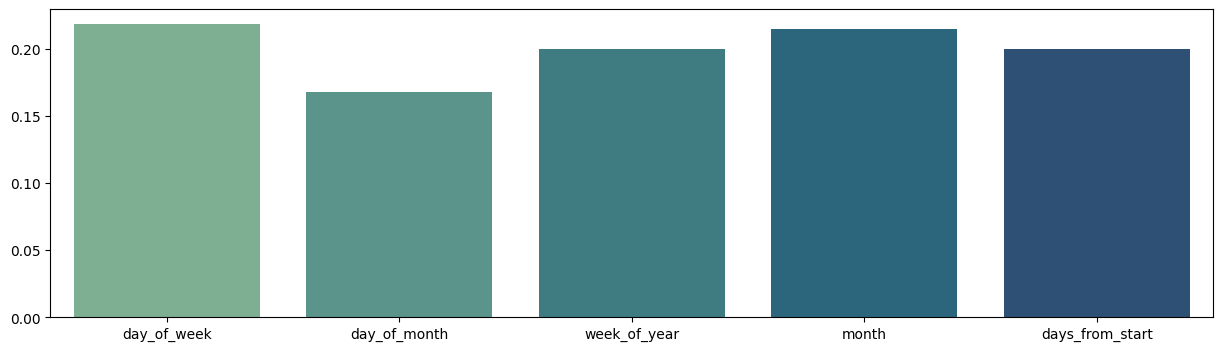


Plotting interpreation plots for a batch of entity 2:


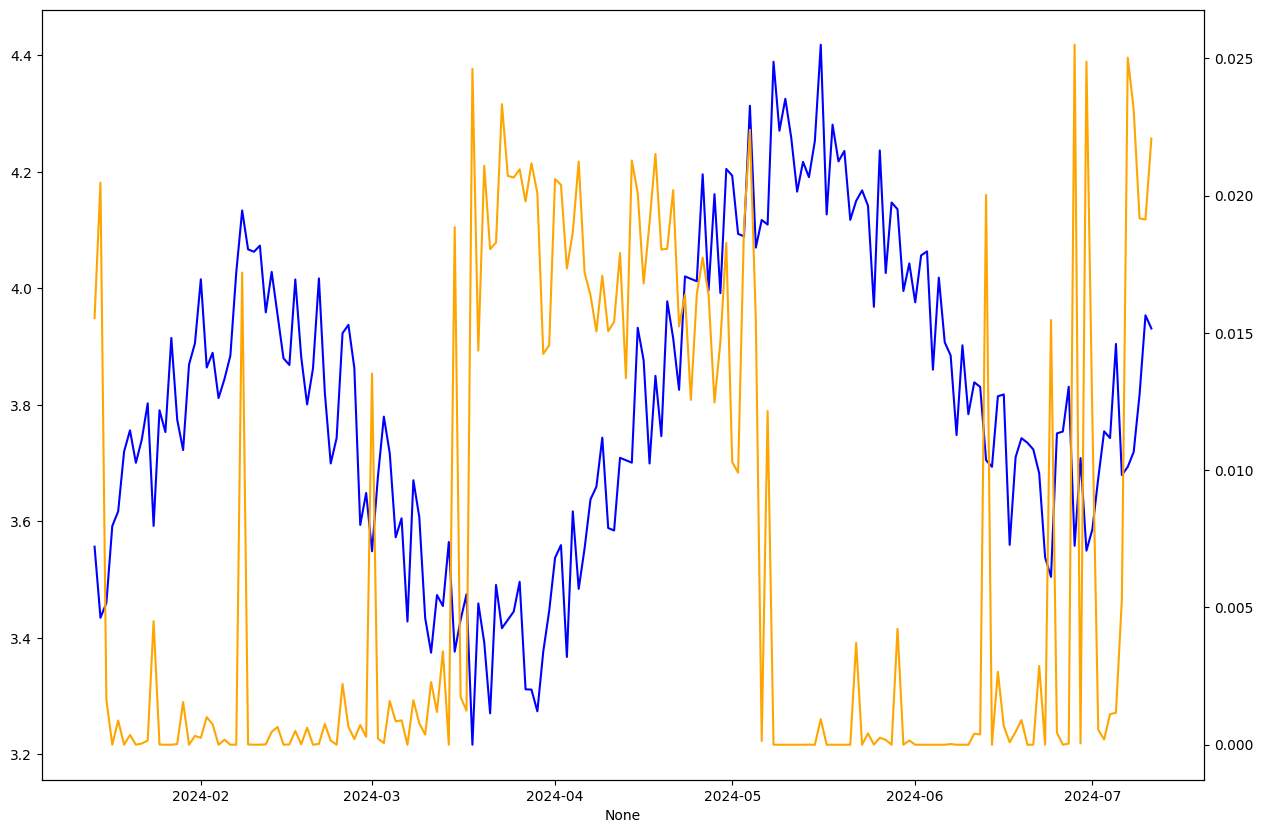

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


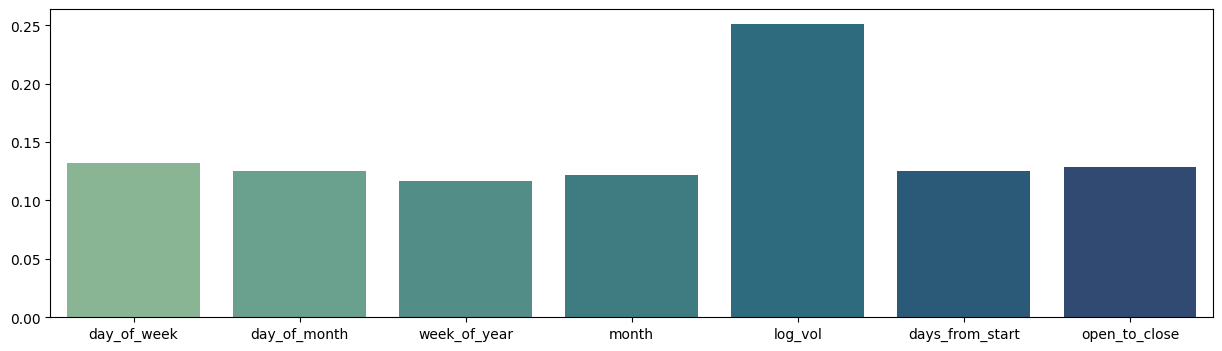

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


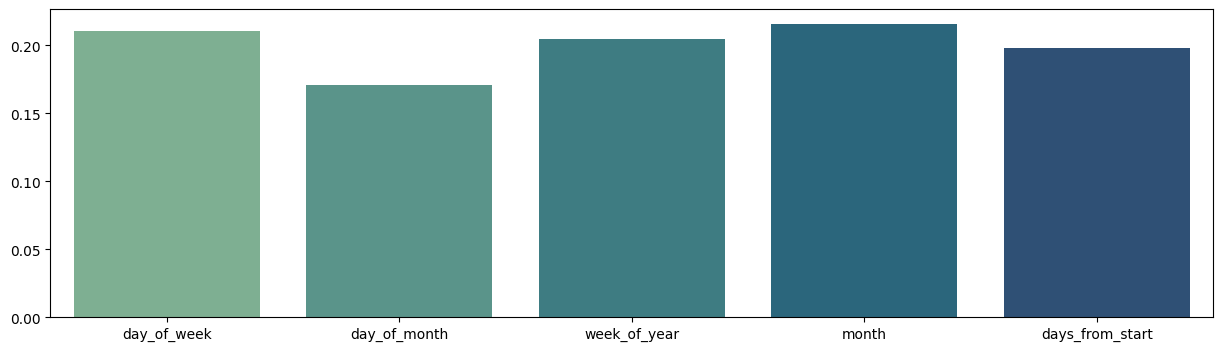


Plotting interpreation plots for a batch of entity 3:


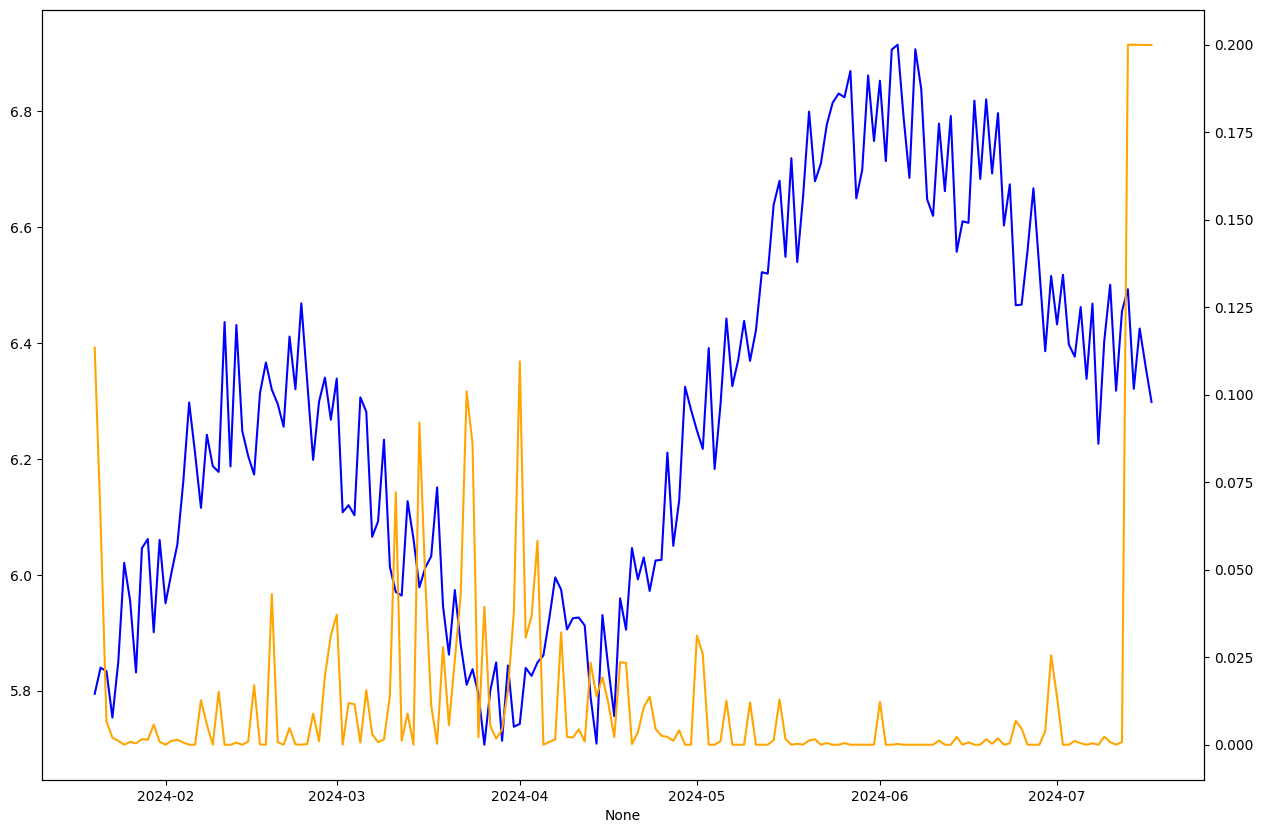

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


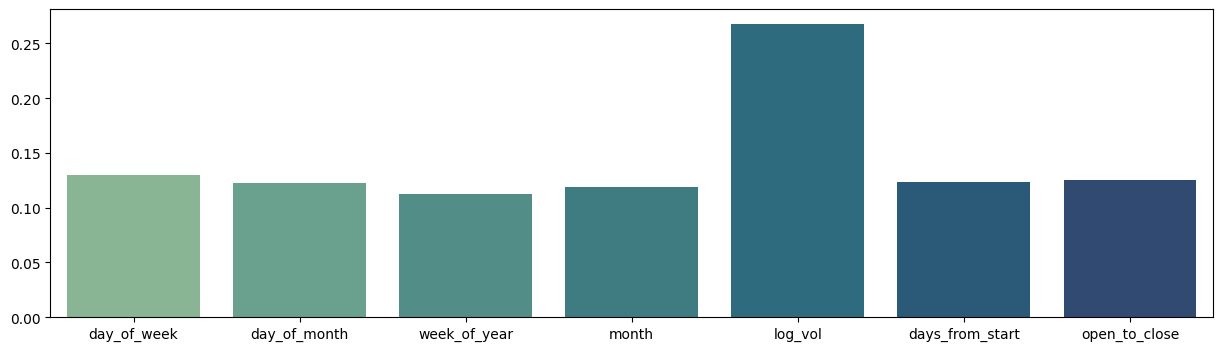

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


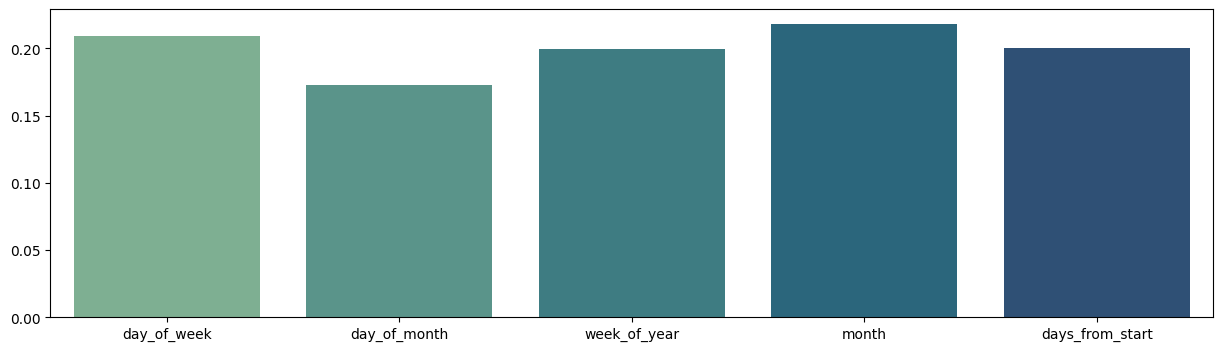


Plotting interpreation plots for a batch of entity 4:


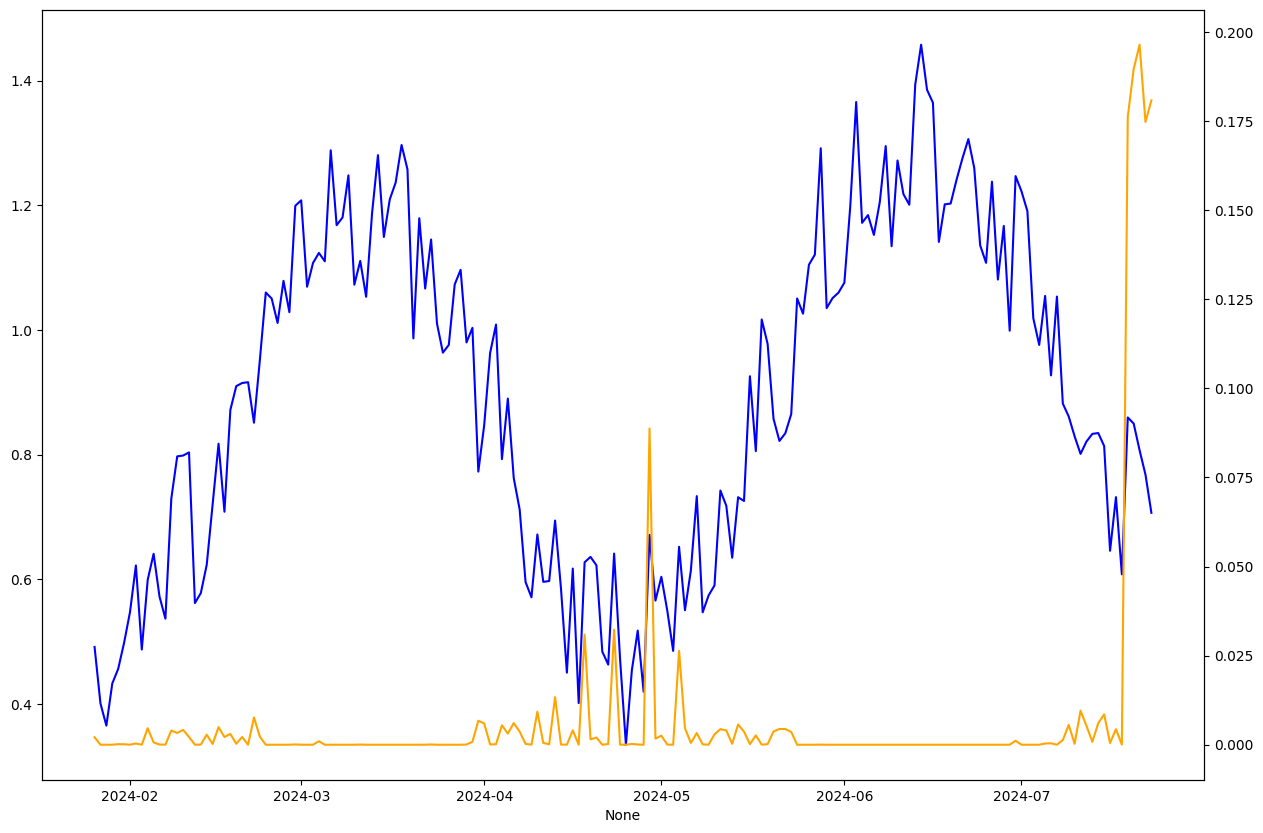

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


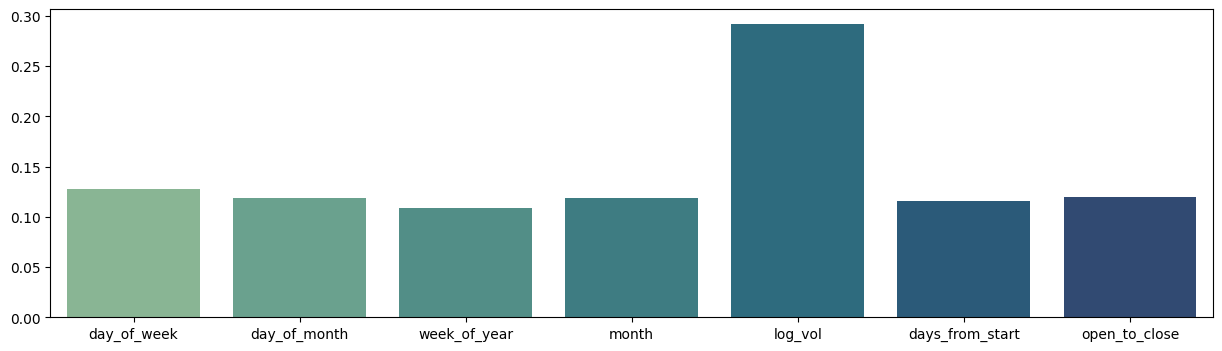

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


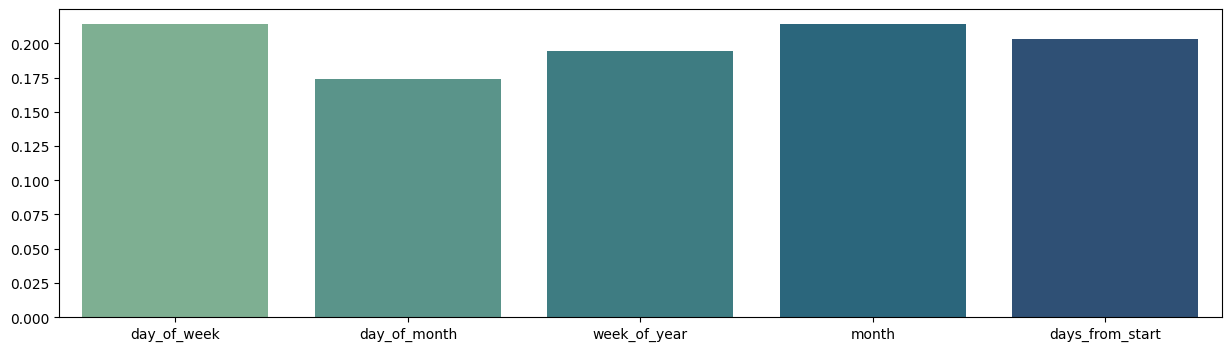


Plotting interpreation plots for a batch of entity 5:


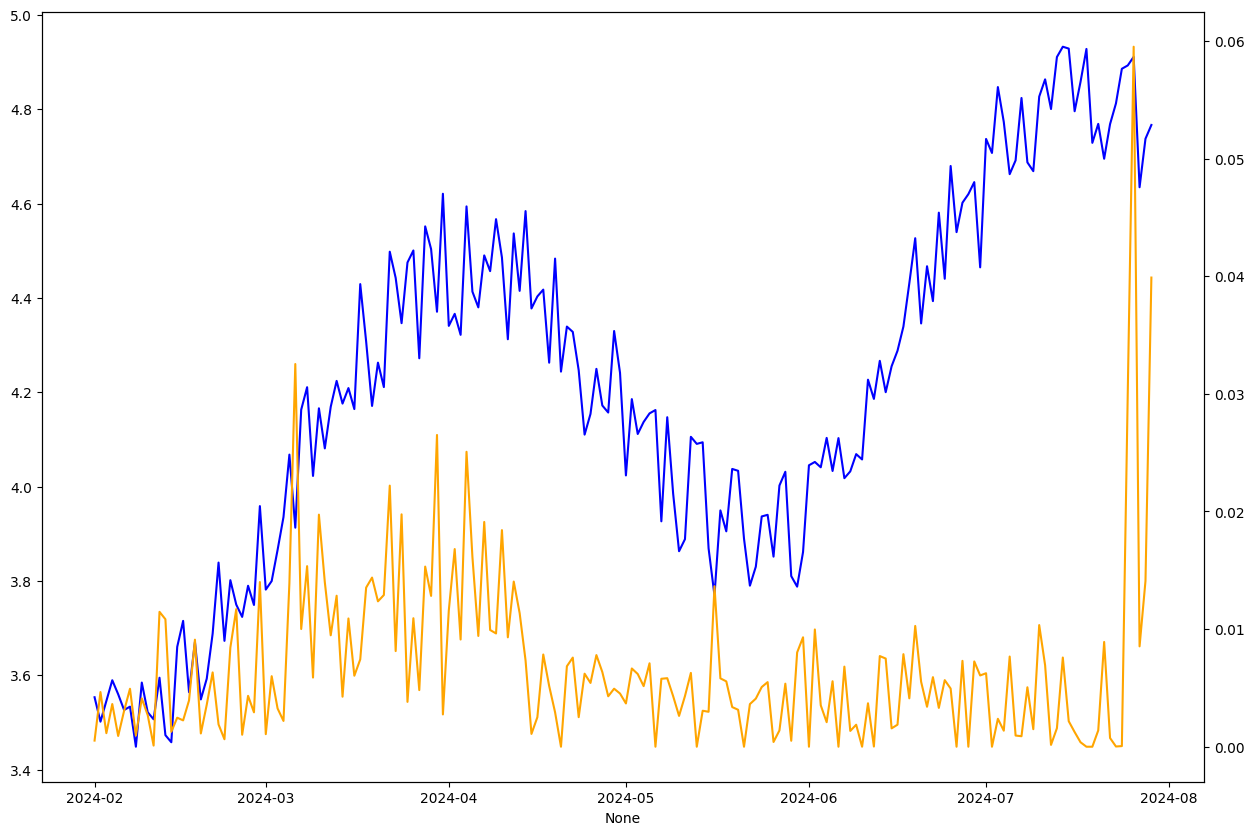

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


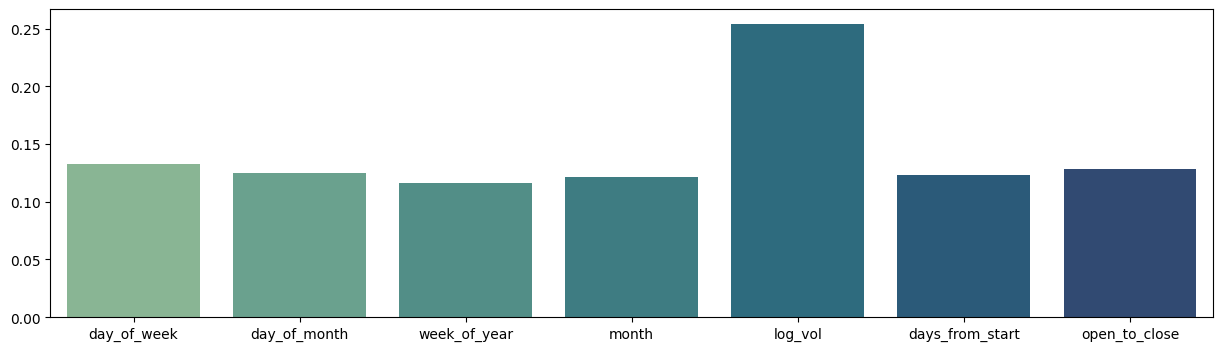

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


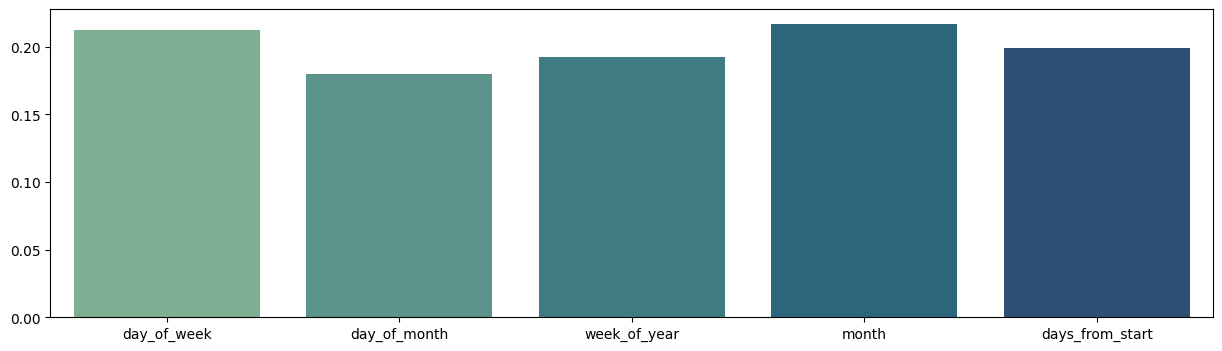


Plotting interpreation plots for a batch of entity 6:


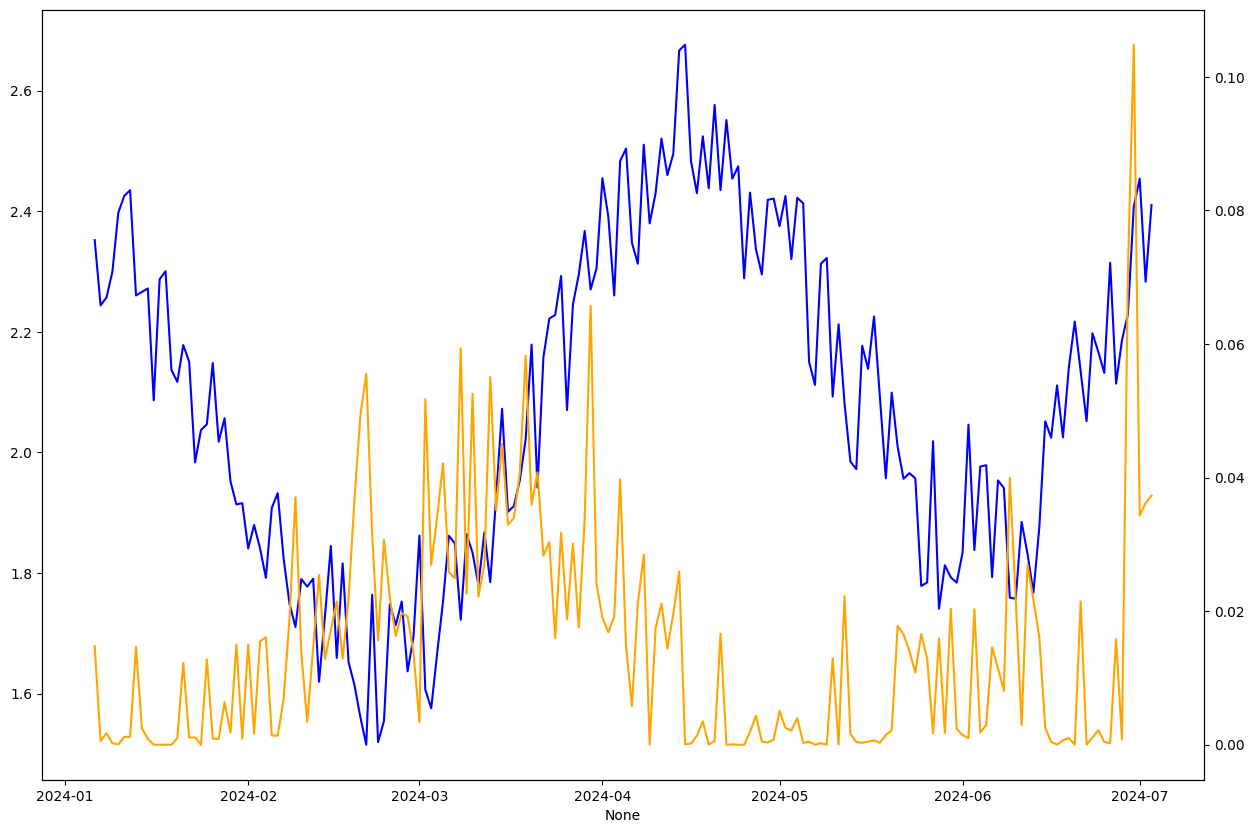

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


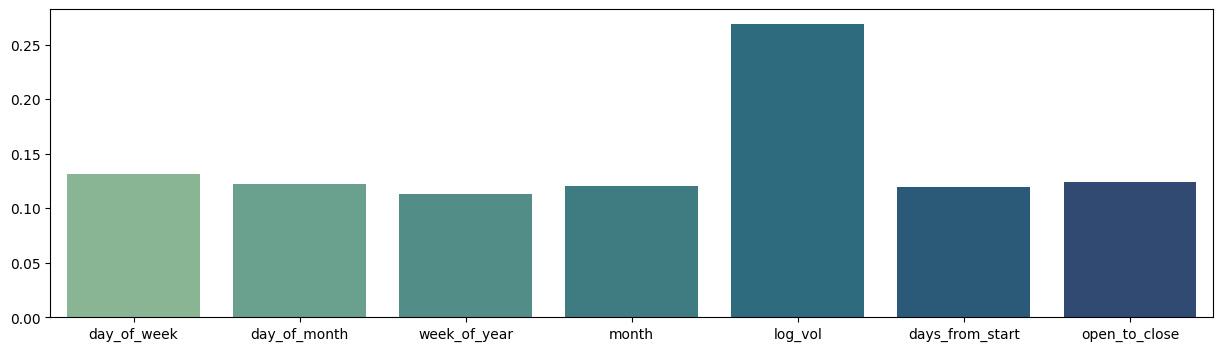

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


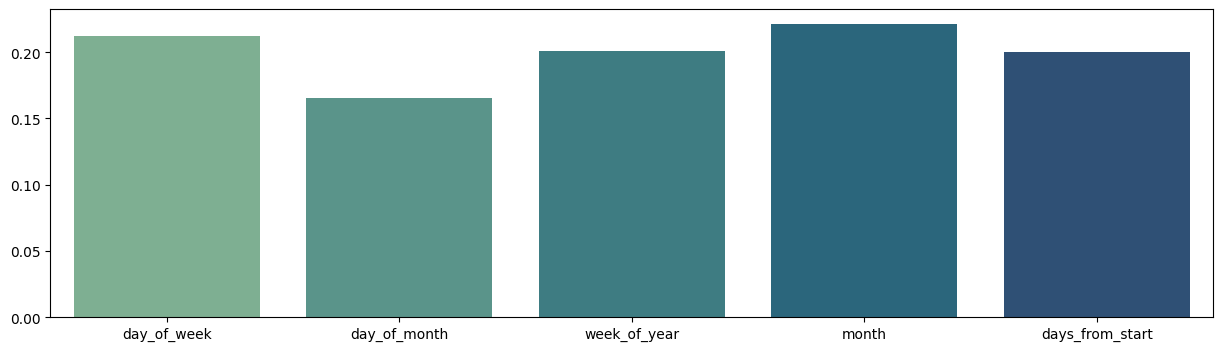


Plotting interpreation plots for a batch of entity 7:


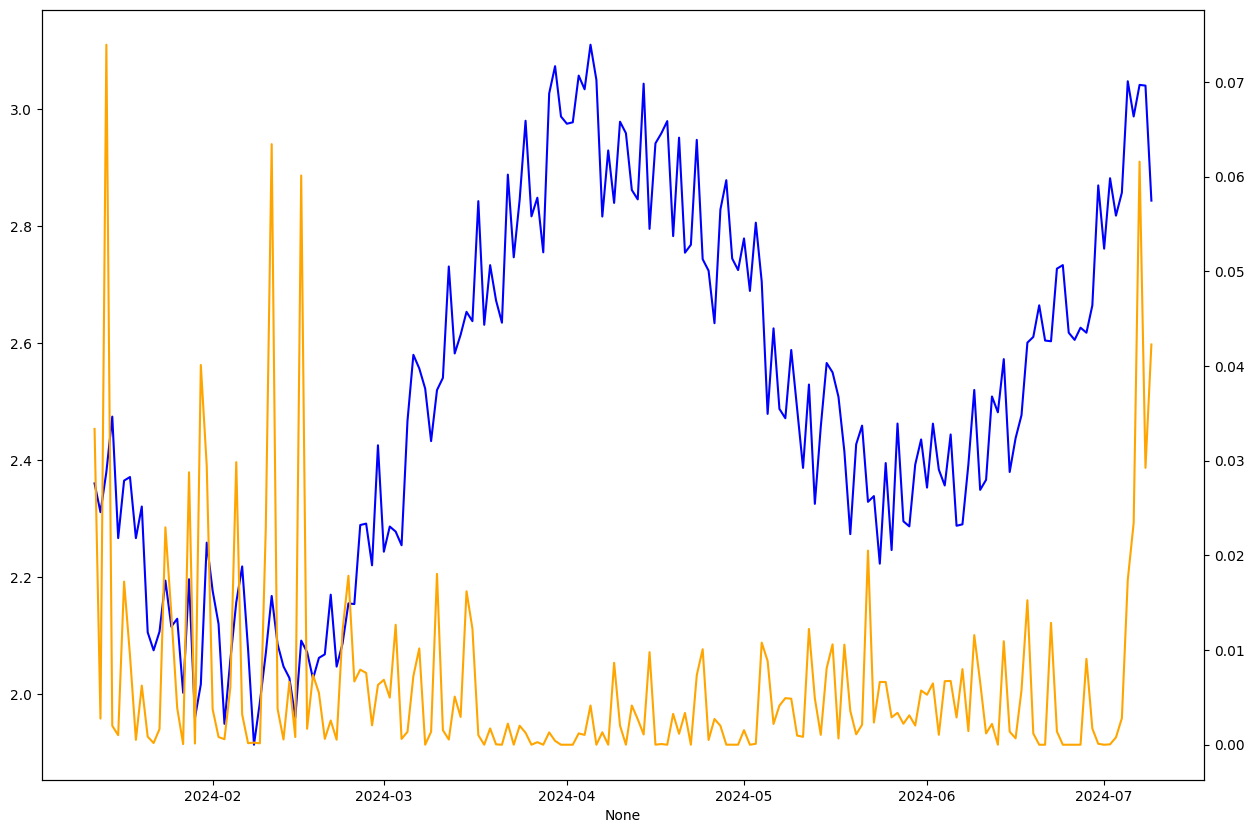

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


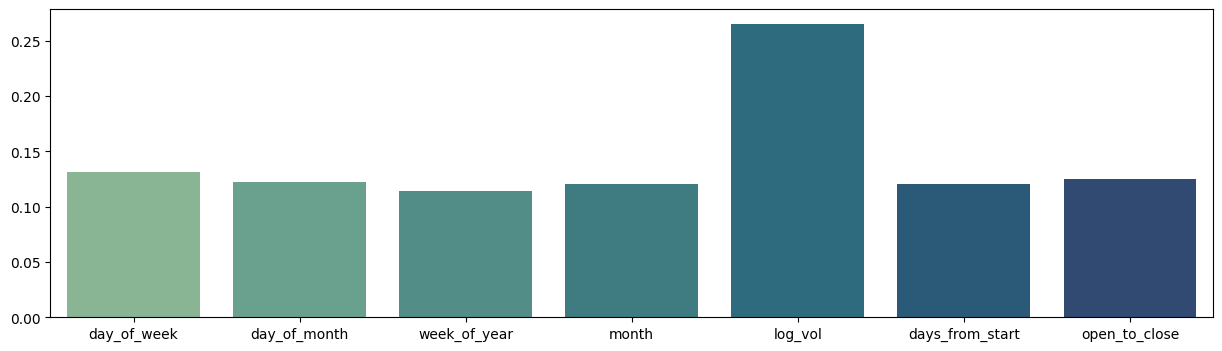

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


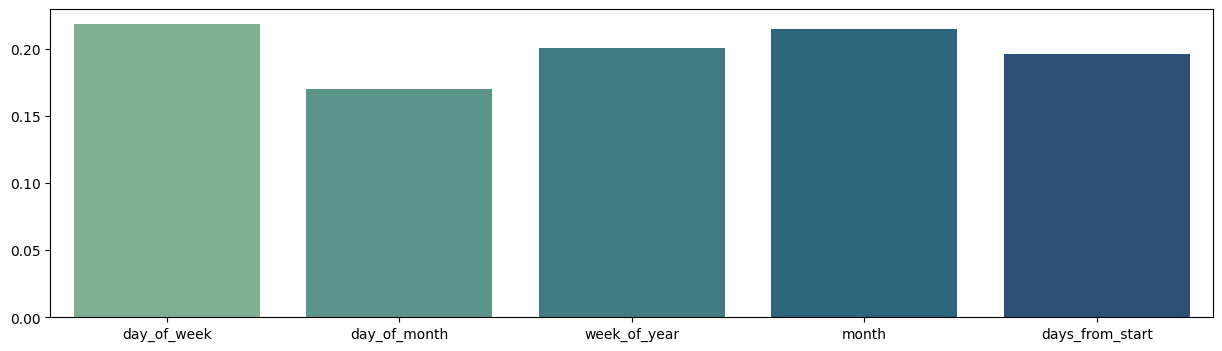


Plotting interpreation plots for a batch of entity 8:


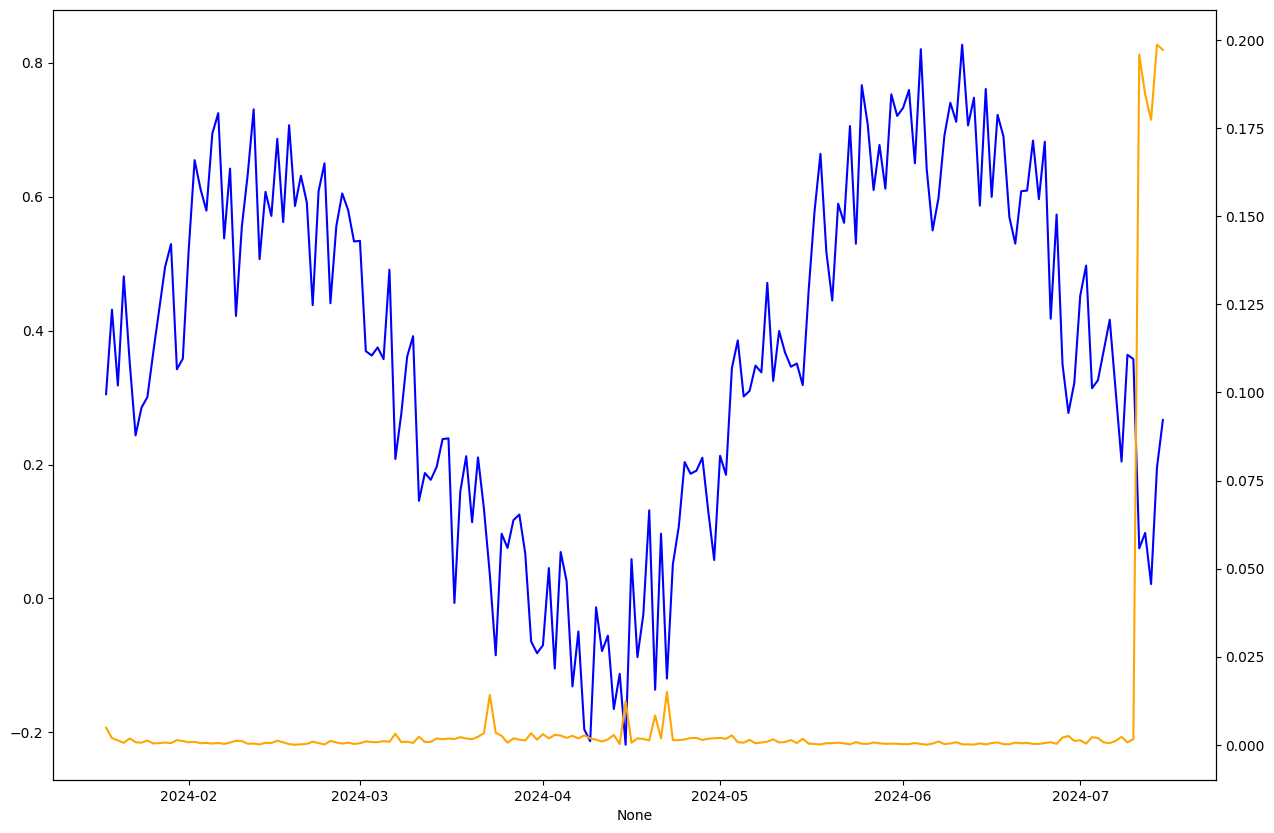

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


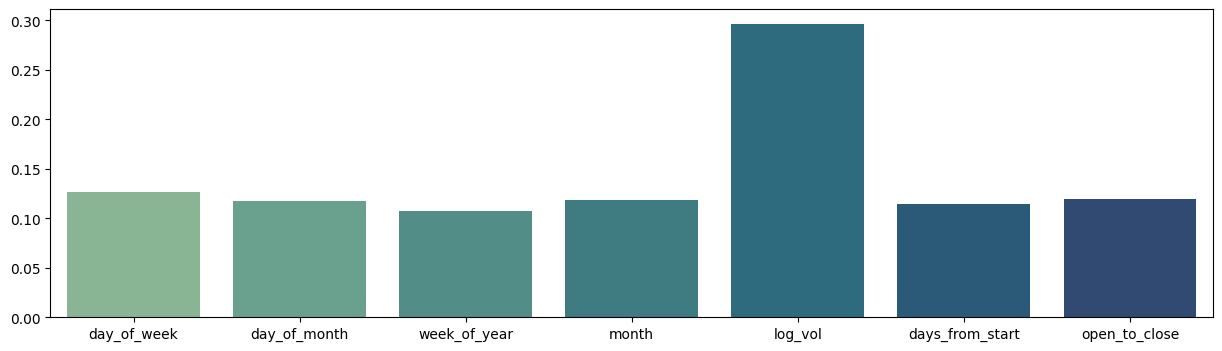

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


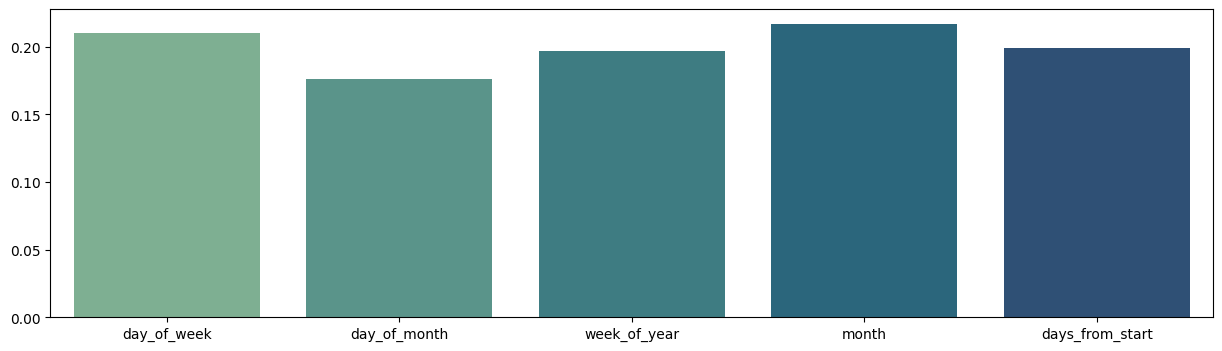


Plotting interpreation plots for a batch of entity 9:


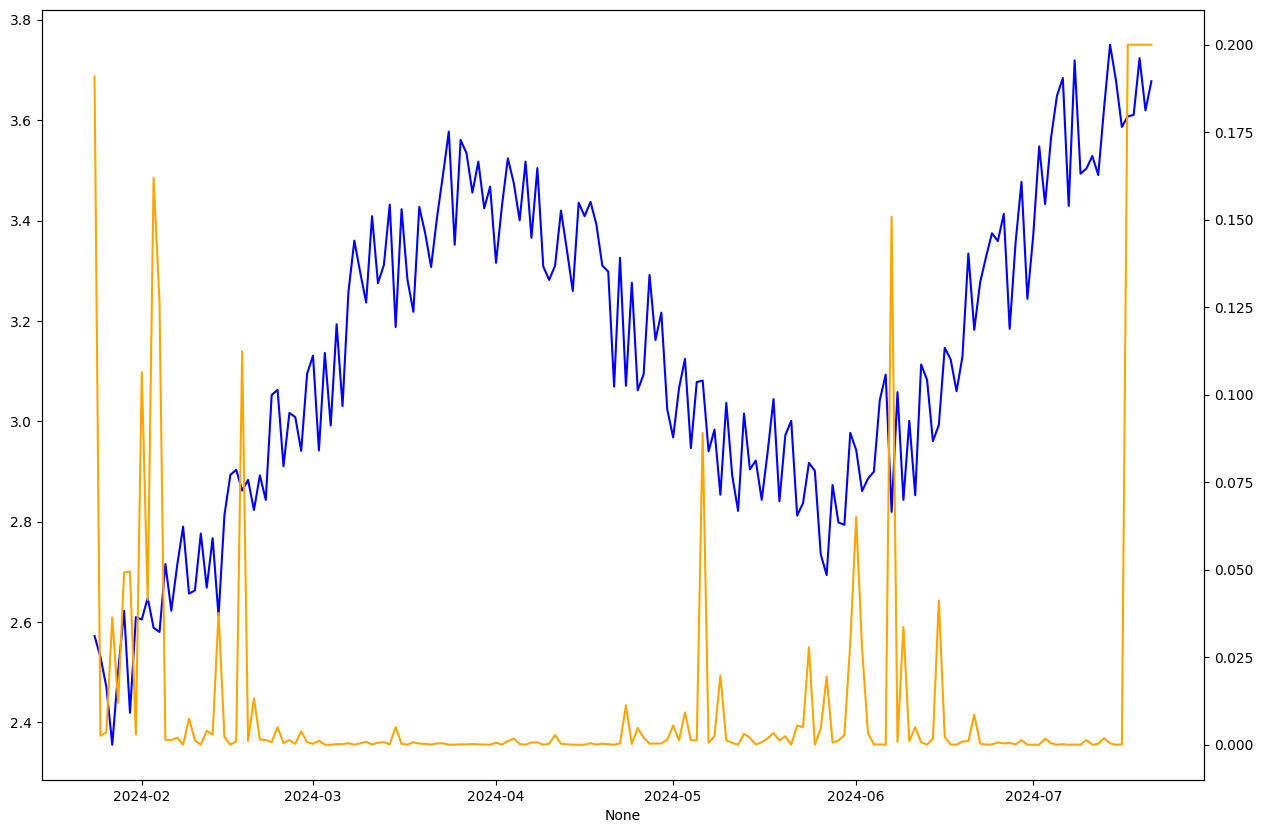

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


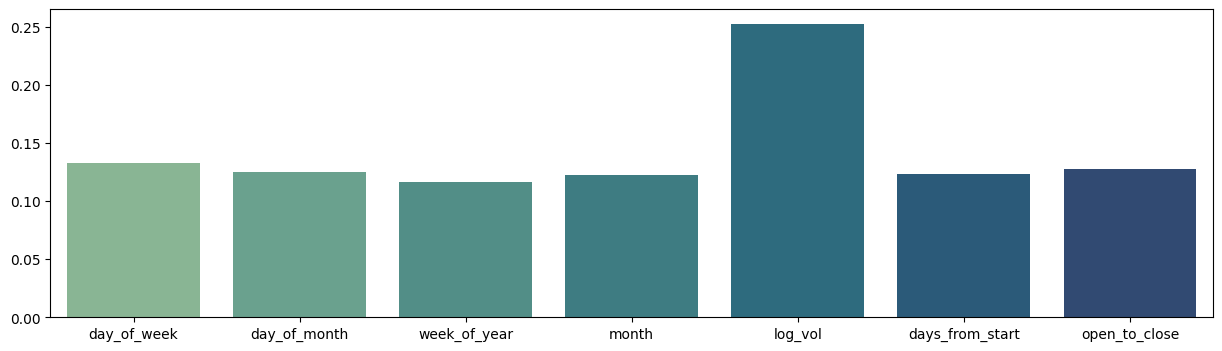

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


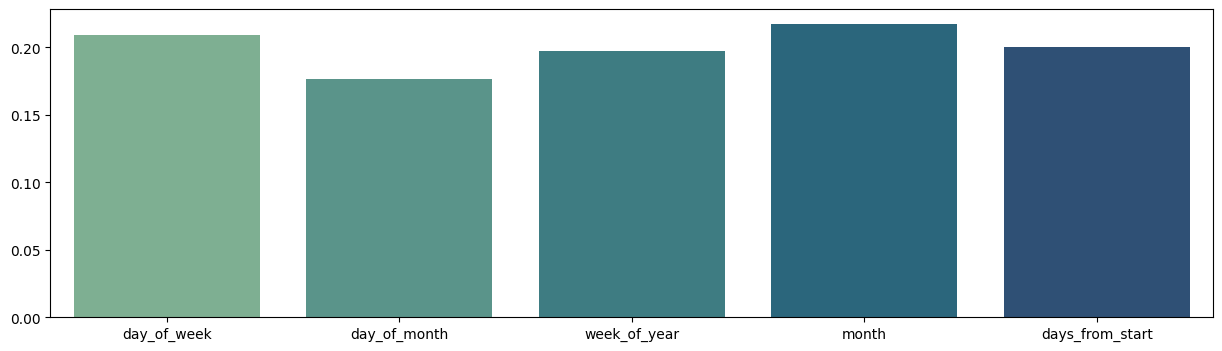


Plotting interpreation plots for a batch of entity 10:


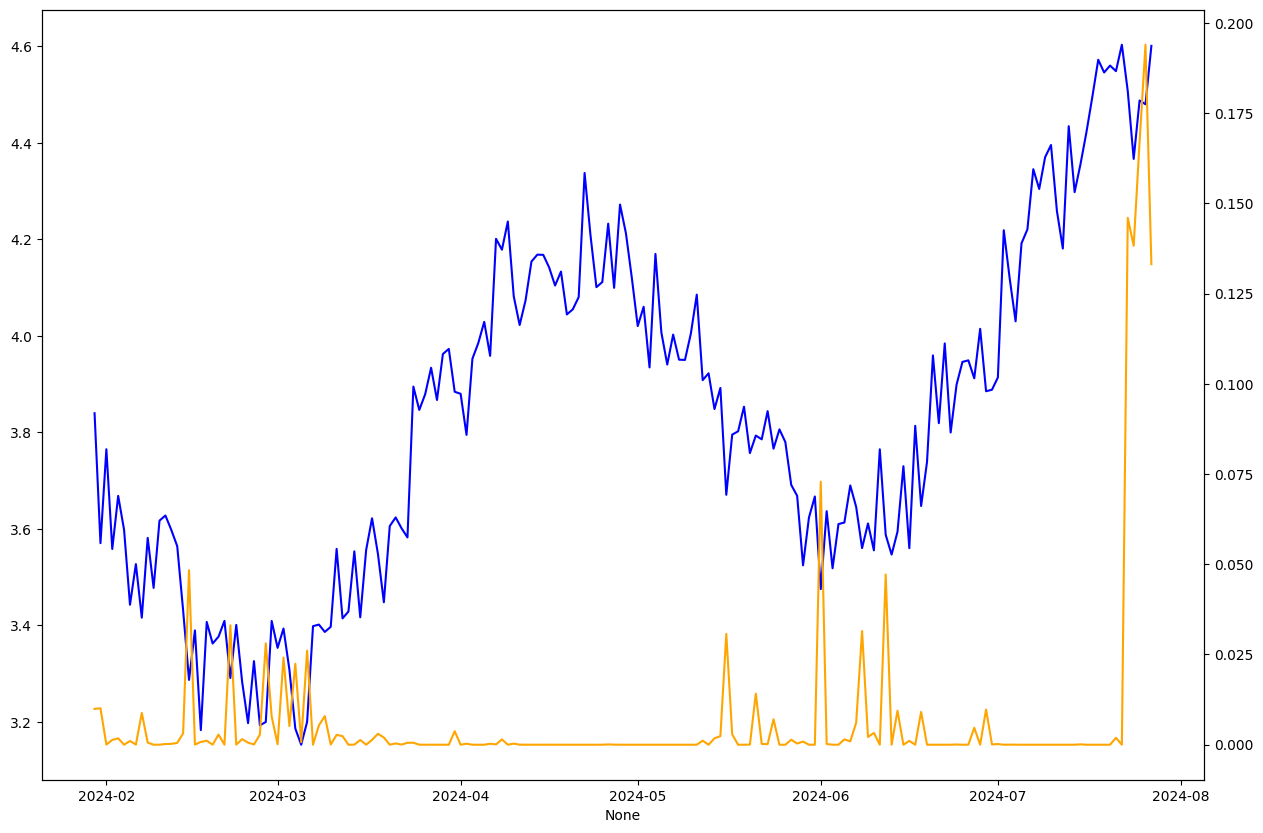

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


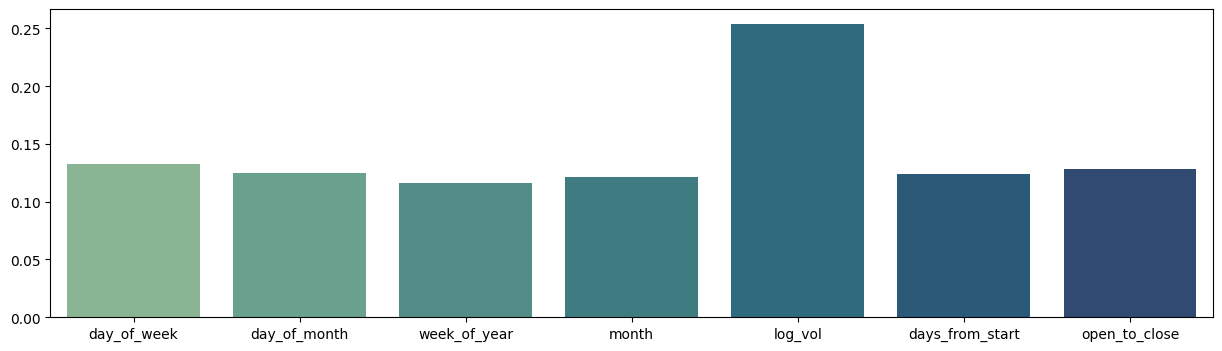

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


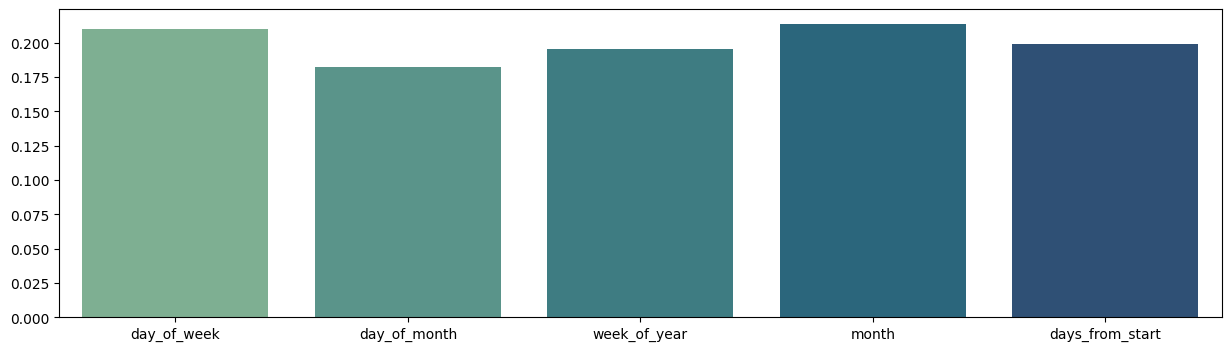


Plotting interpreation plots for a batch of entity 11:


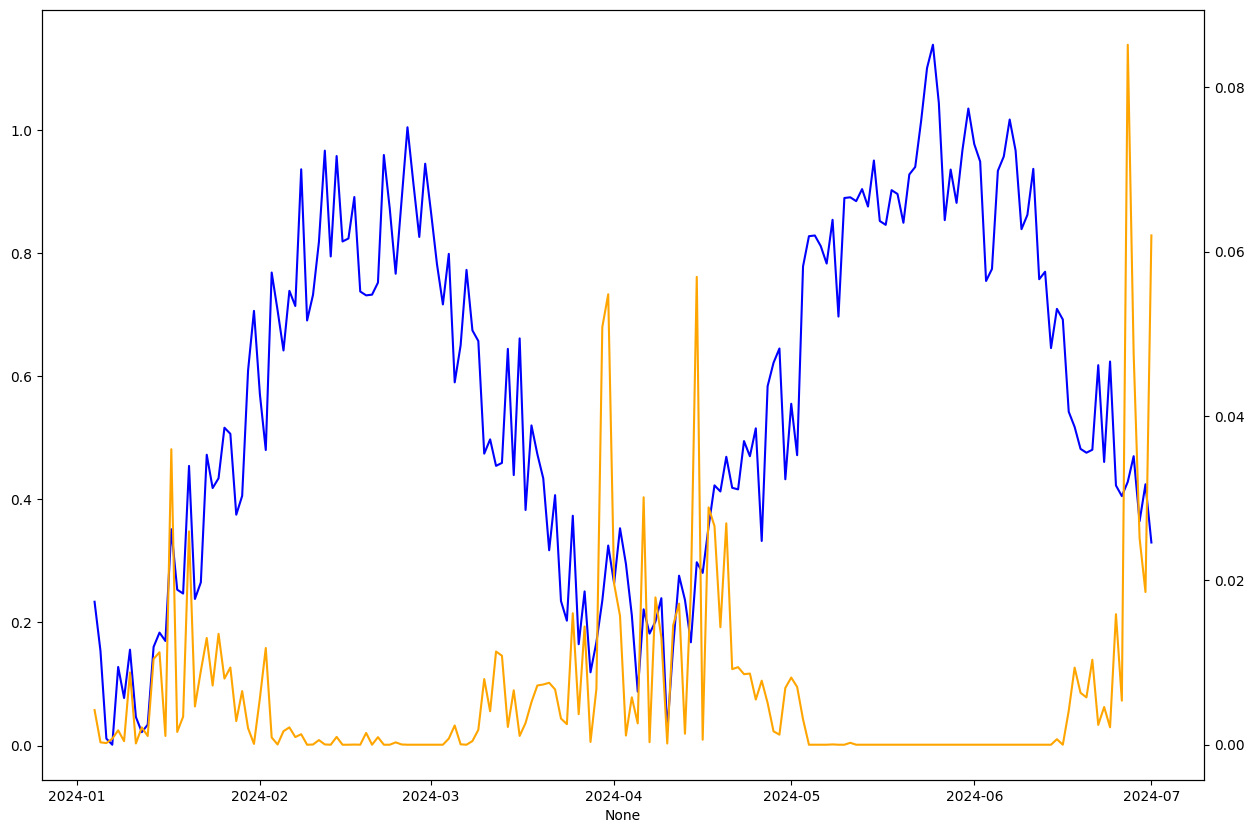

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


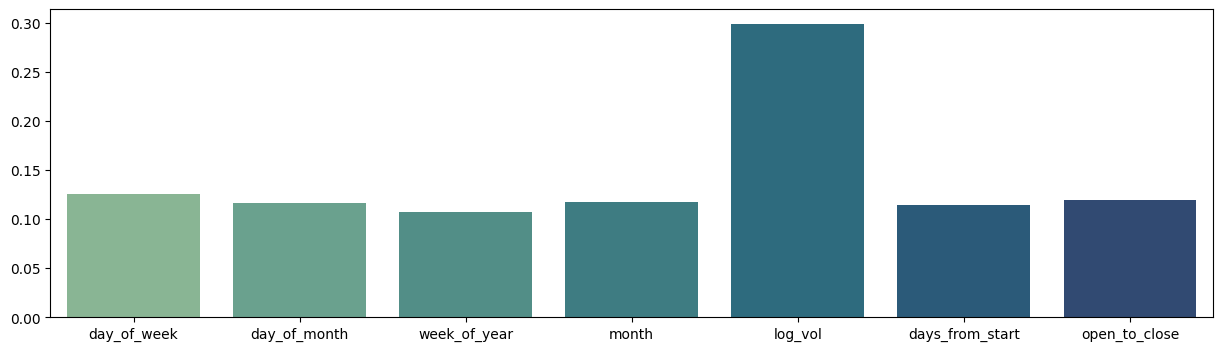

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


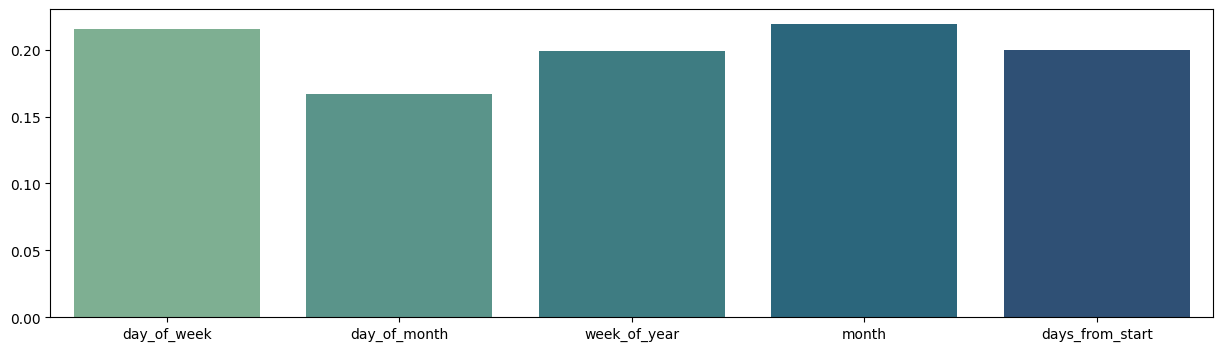


Plotting interpreation plots for a batch of entity 12:


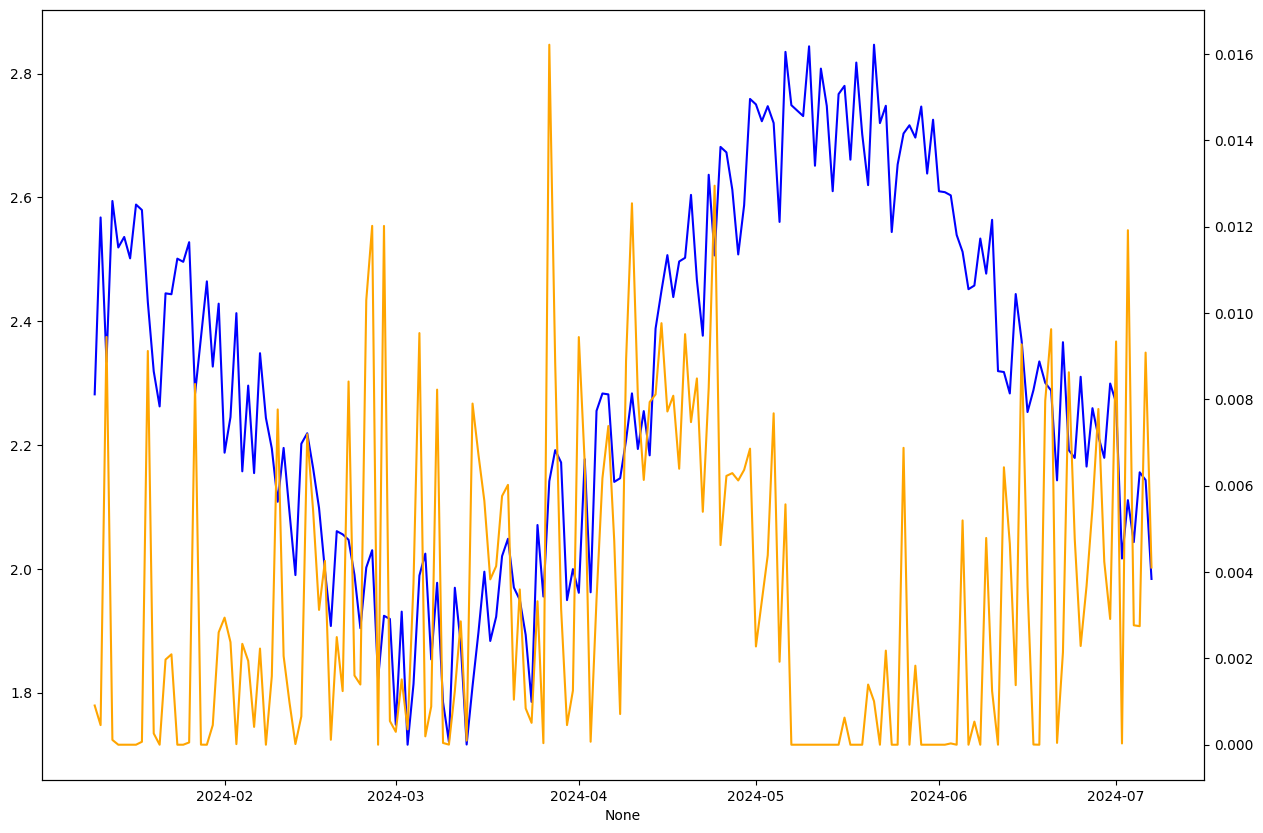

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


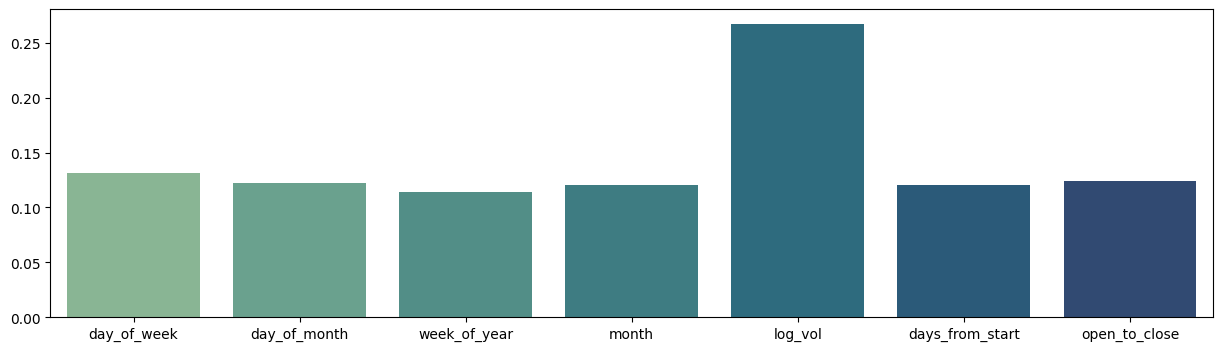

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


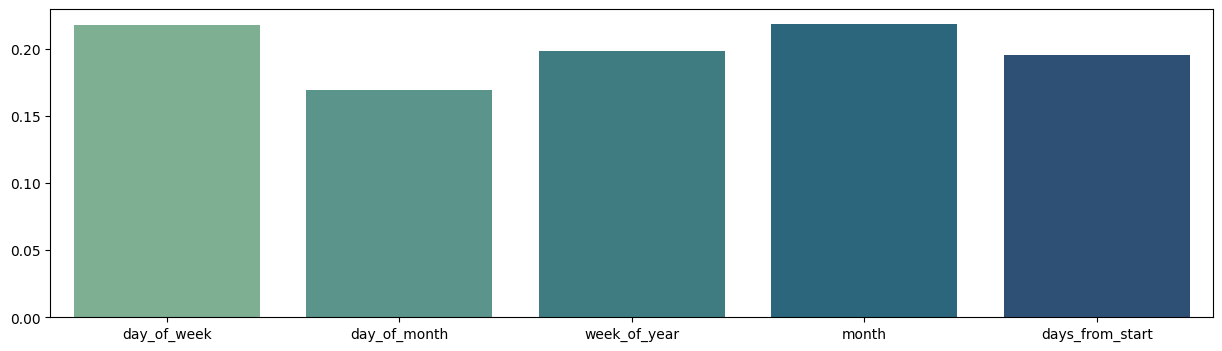


Plotting interpreation plots for a batch of entity 13:


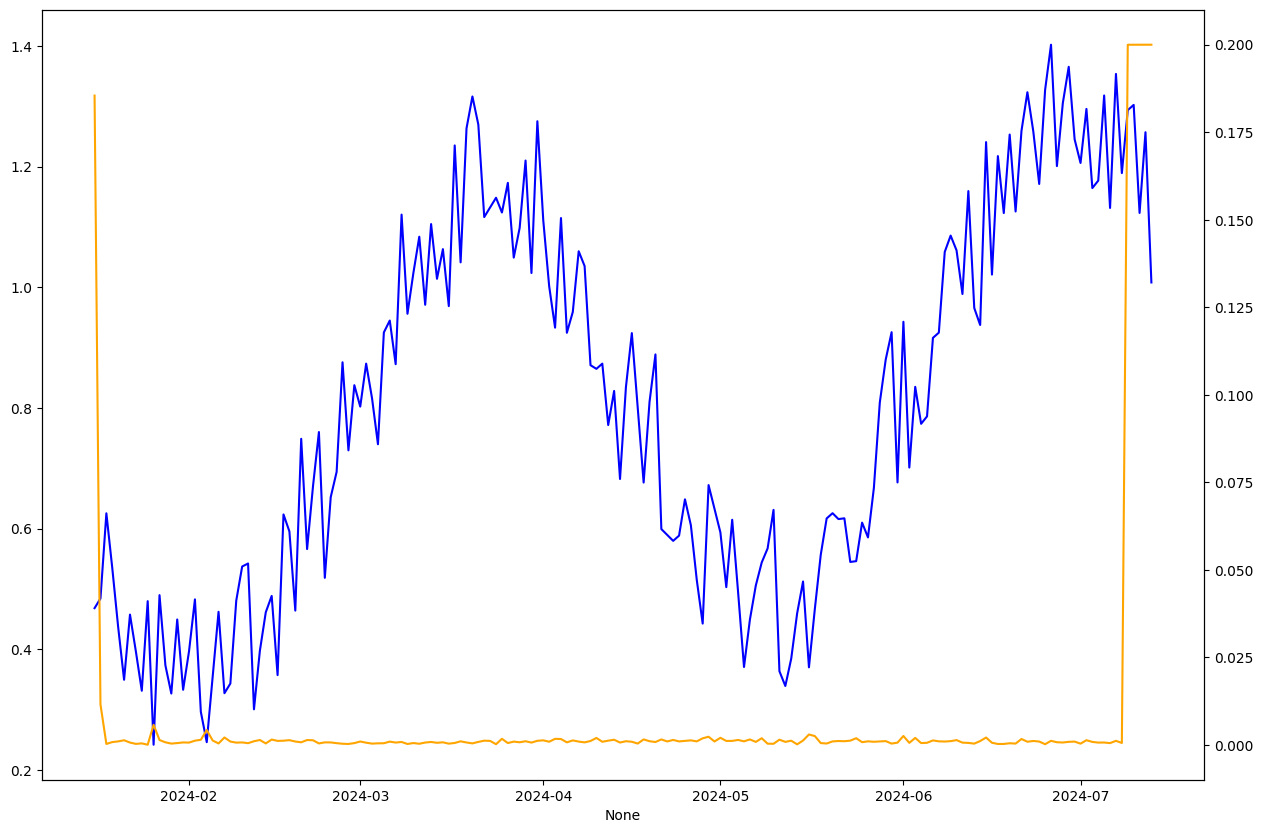

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


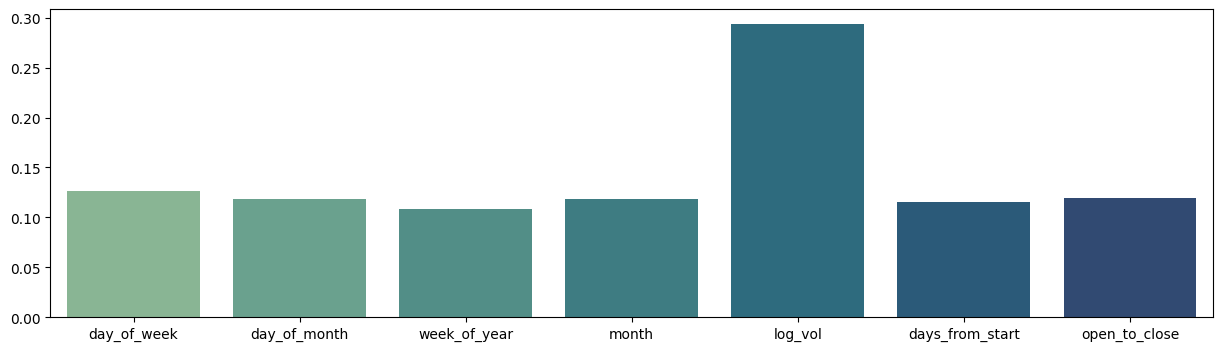

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


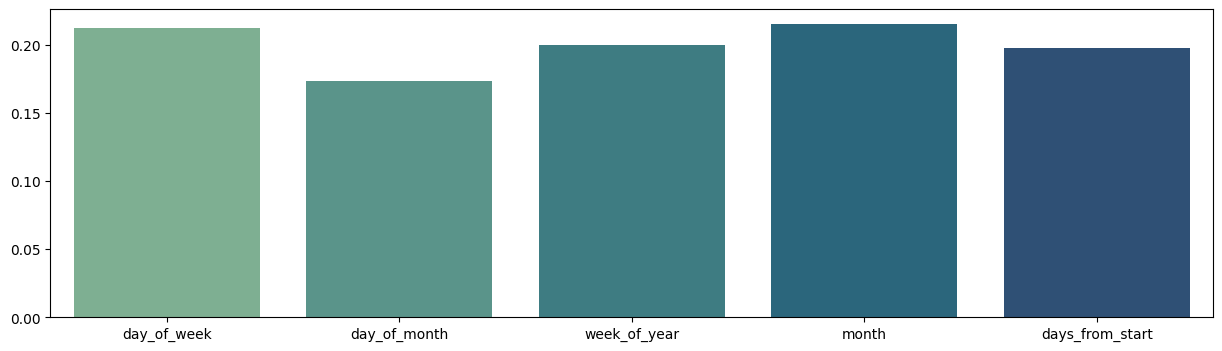


Plotting interpreation plots for a batch of entity 14:


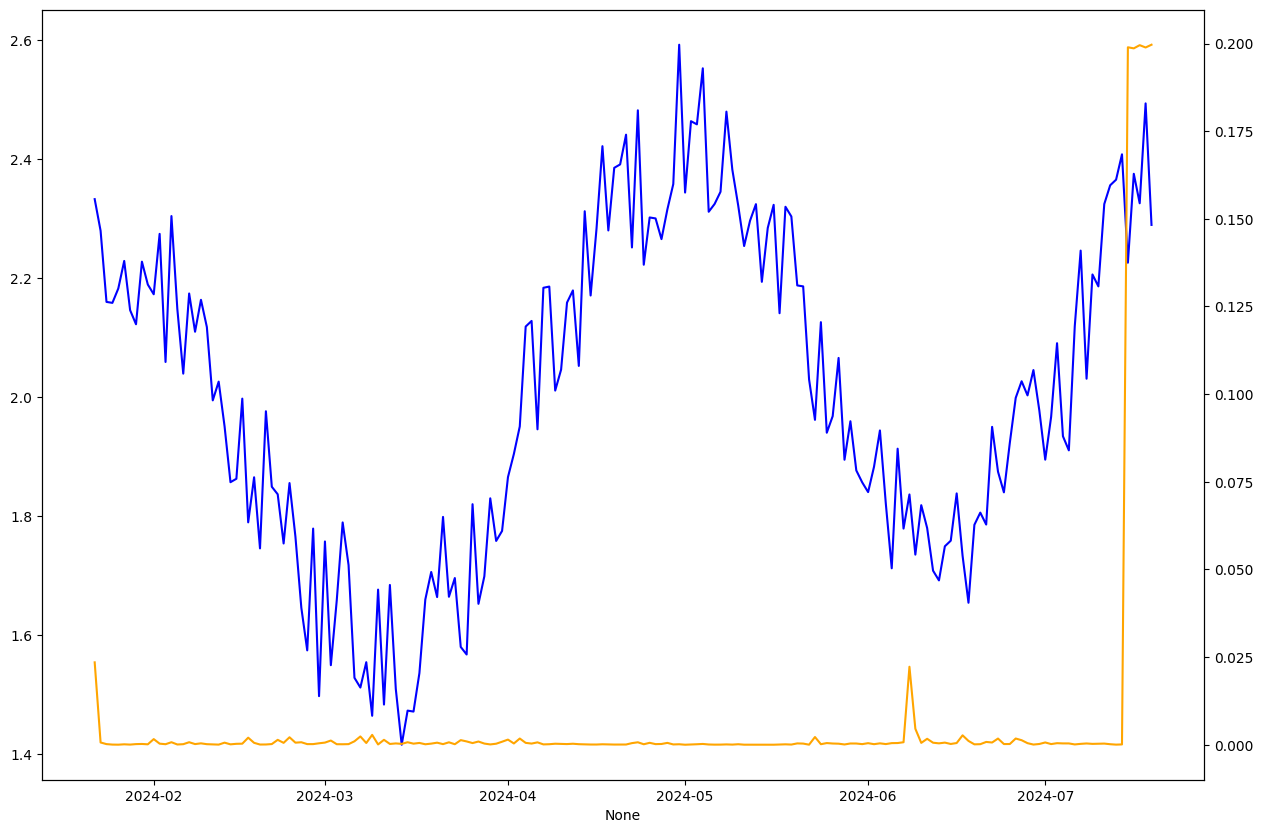

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


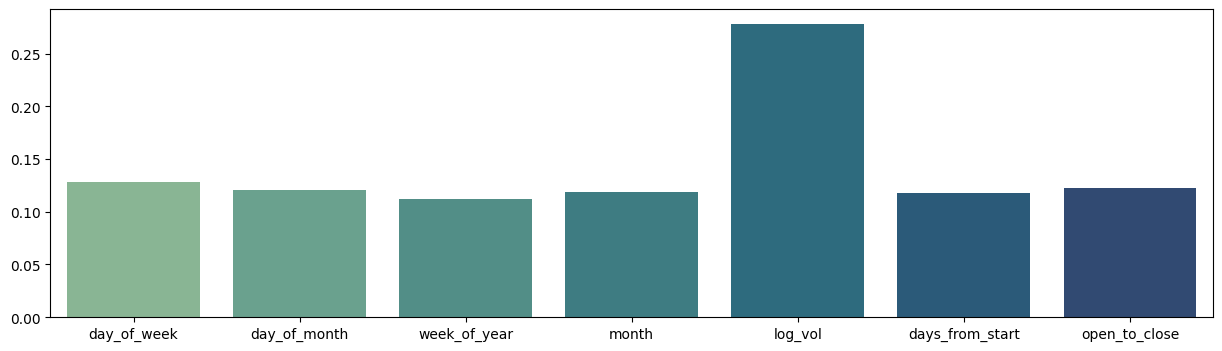

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


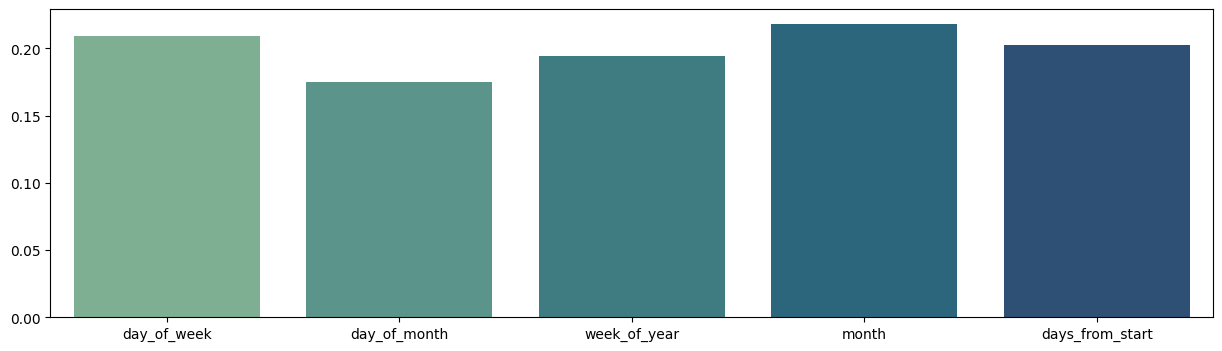


Plotting interpreation plots for a batch of entity 15:


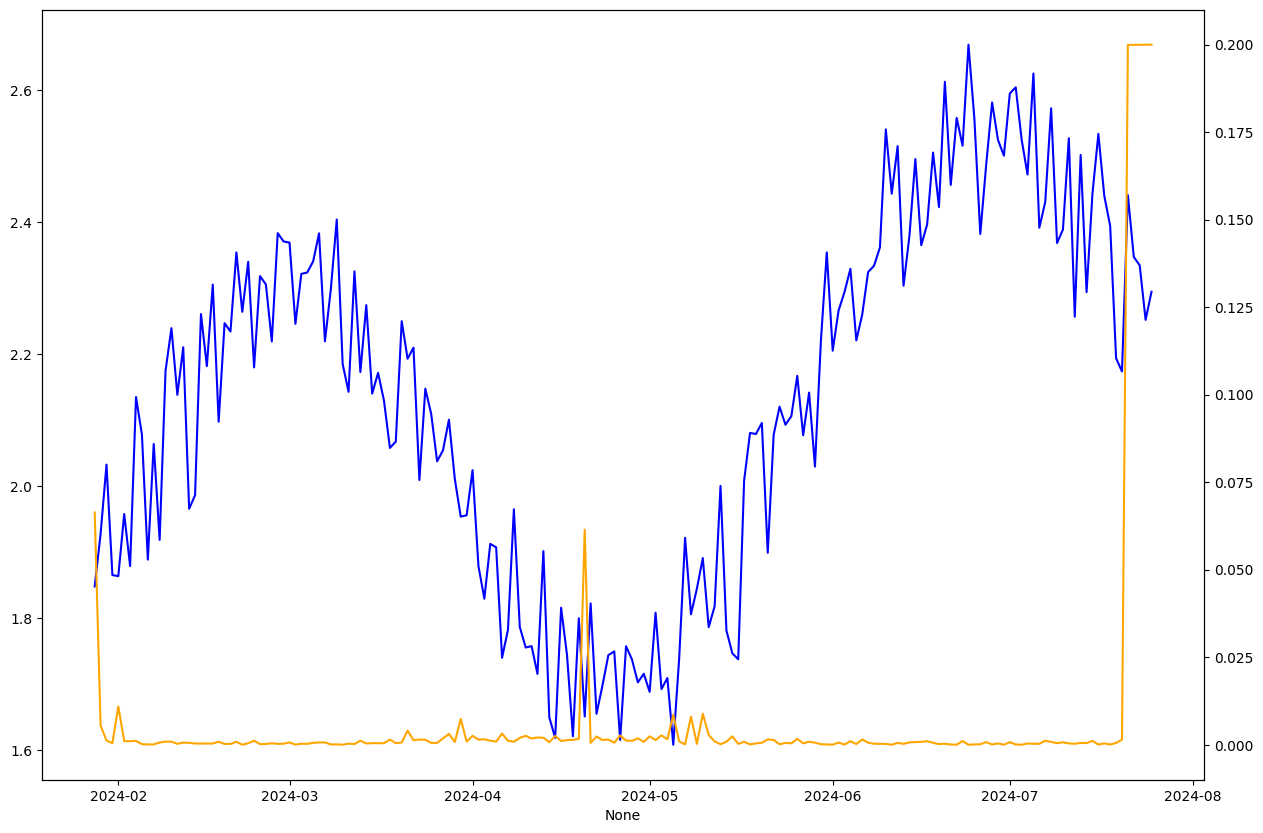

<ipython-input-24-3c82d9cc93d8>:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=past_inputs,


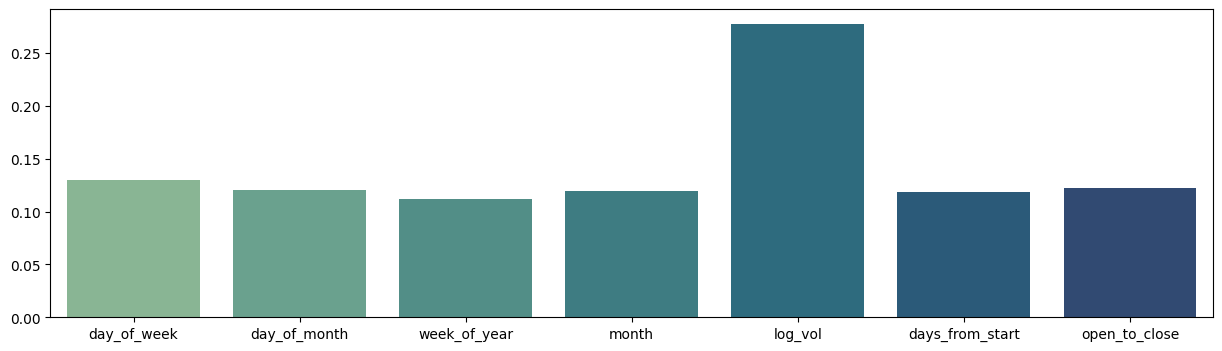

<ipython-input-24-3c82d9cc93d8>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=future_inputs,


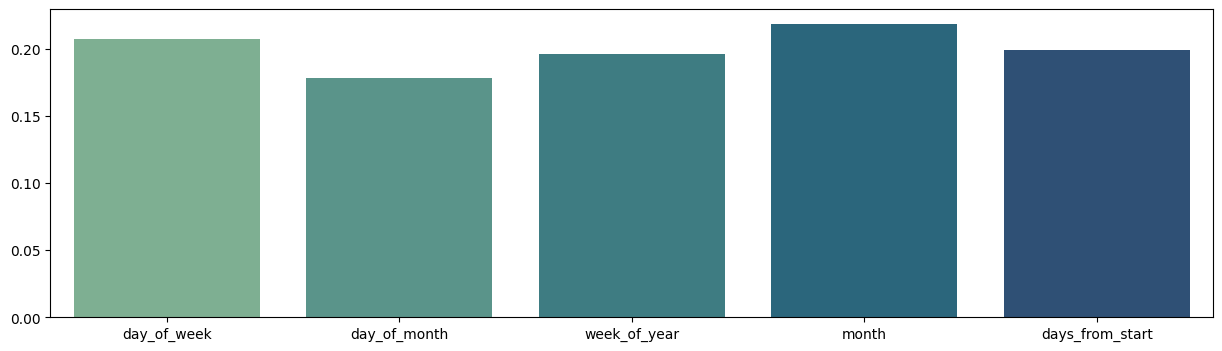

In [24]:
out_df = pd.DataFrame(columns=['p10', 'p50', 'p90', 'identifier'])

start_id = -1

for i, batch in enumerate(test_dataloader):

    outputs, attention_weights = model(batch)
    bs = batch["outputs"].shape[0]

    process_map = {f"p{int(q * 100)}": outputs.reshape(bs, 5, 3)[:, :, i].cpu().detach().numpy()[::5,:].reshape(-1)[:bs] for i, q in enumerate(QUANTILES)}

    tmp = pd.DataFrame(data=process_map, index=pd.to_datetime(batch['time'][:, ENCODER_STEPS - 1, 0]))
    tmp["labels"] = batch["outputs"].reshape(-1)[::5]
    tmp["identifier"] = batch['identifier'][:, 0, 0]

    out_df = pd.concat([out_df, tmp])

    e = int(batch['identifier'][0, 0, 0].numpy())
    if batch['identifier'][0, 0, 0].numpy() != start_id:

        print("="*20)
        print(f"Plotting interpreation plots for a batch of entity {e}:")

        id_mask = batch['identifier'][:, 0, 0]==e

        #Plotting multi-head attention
        plt.figure(figsize=(15,10))
        sns.lineplot(x=pd.to_datetime(batch["time"][0,:,0].numpy()),
                     y=batch["inputs"][0,:,0].numpy(), color="blue")
        ax2 = plt.twinx()
        sns.lineplot(x=pd.to_datetime(batch["time"][0,:,0].numpy()),
                     y=attention_weights['multihead_attention'][0].cpu().detach().numpy()[:, 175:].mean(axis=1),
                     ax=ax2, color="orange")
        plt.show()

        past_inputs = ["day_of_week", "day_of_month", "week_of_year", "month", 'log_vol', 'days_from_start', "open_to_close"]
        future_inputs = ["day_of_week", "day_of_month", "week_of_year", "month", "days_from_start"]

        # Plotting past weights
        plt.figure(figsize=(15,4))
        sns.barplot(x=past_inputs,
                    y=attention_weights['past_weights'][id_mask,:,:].mean(dim=(0,1)).cpu().detach().numpy(),
                    palette="crest")
        plt.show()

        # Plotting future weights
        plt.figure(figsize=(15,4))
        sns.barplot(x=future_inputs,
                    y=attention_weights['future_weights'][id_mask,:,:].mean(dim=(0,1)).cpu().detach().numpy(),
                    palette="crest")
        plt.show()
        start_id = e
        print()

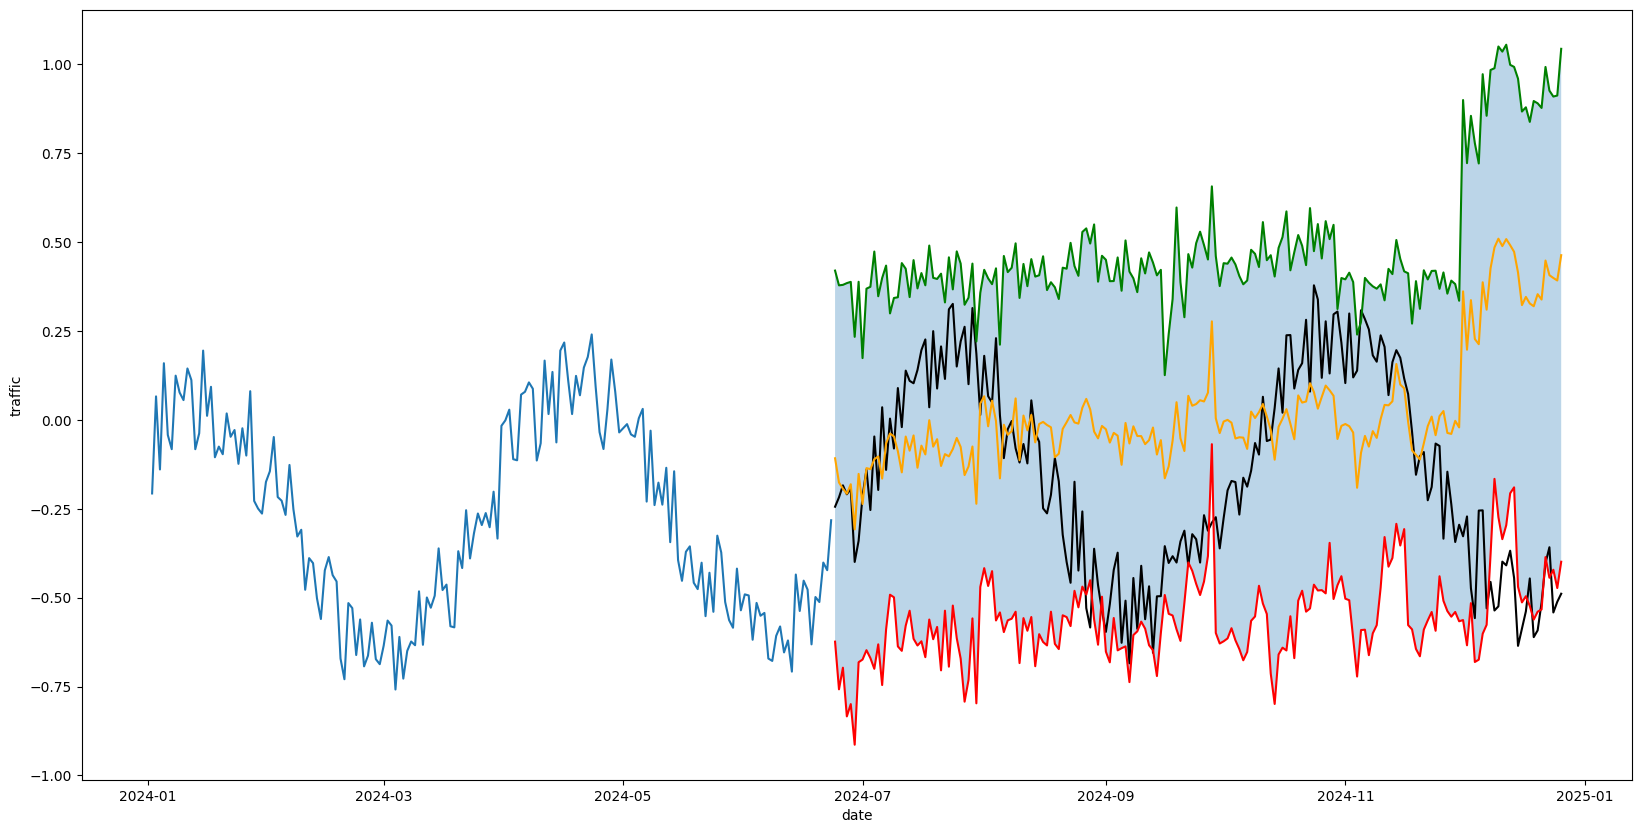

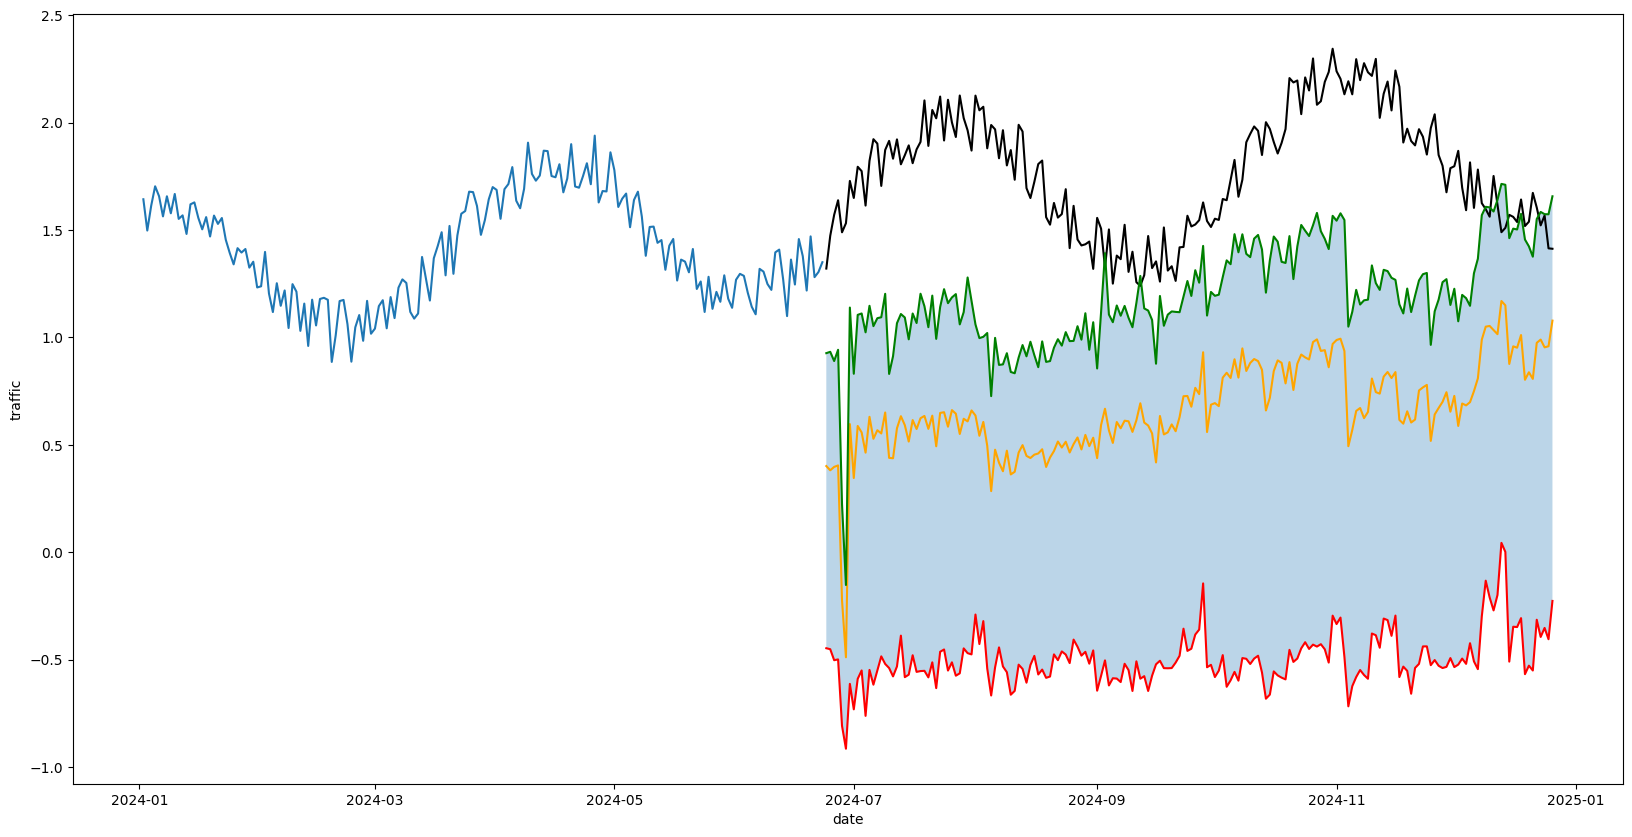

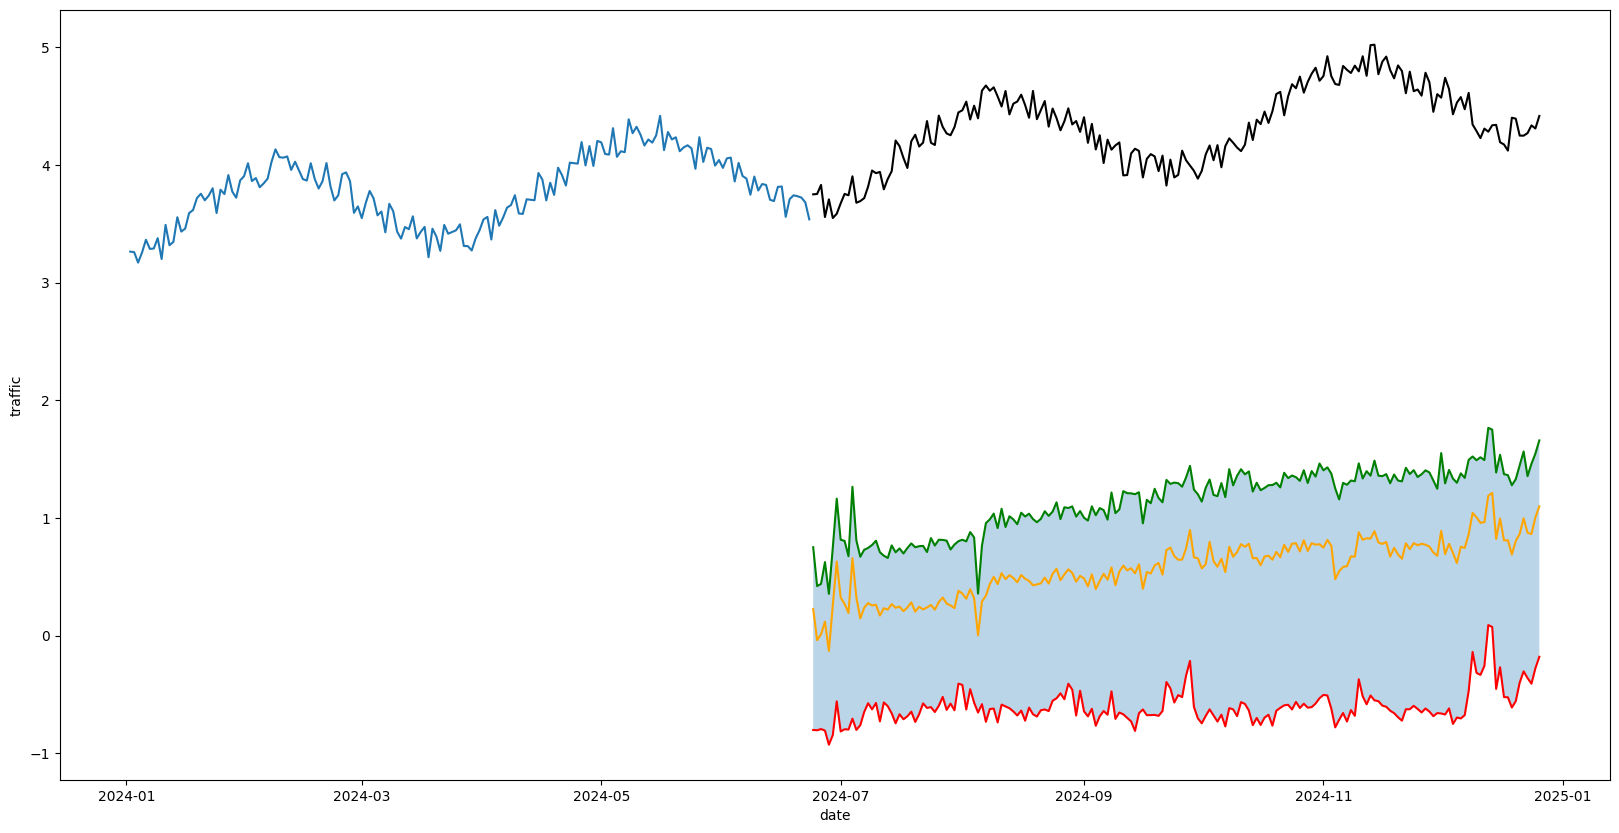

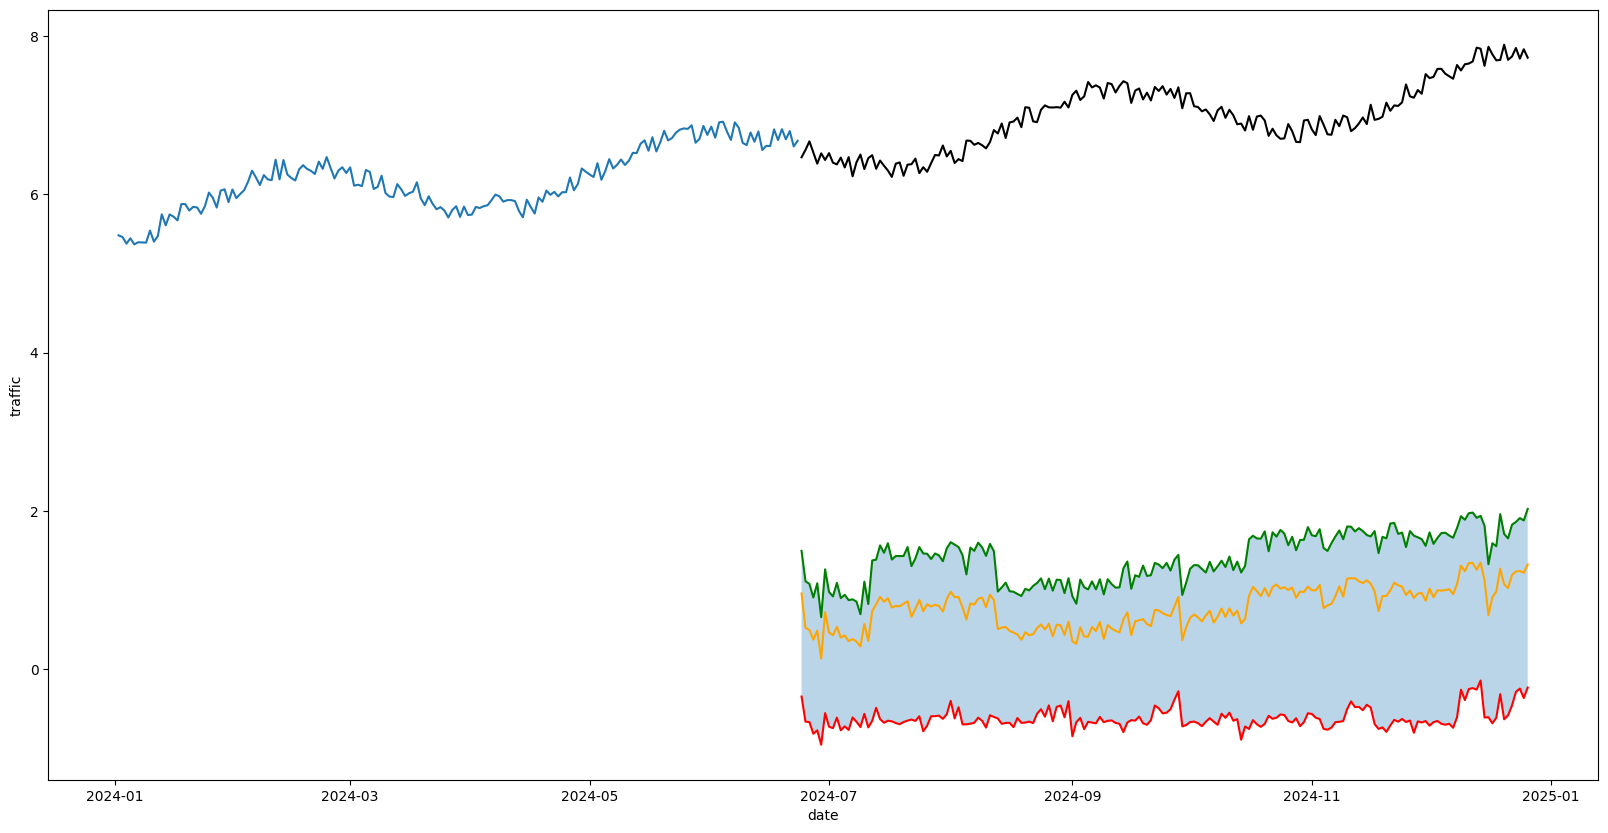

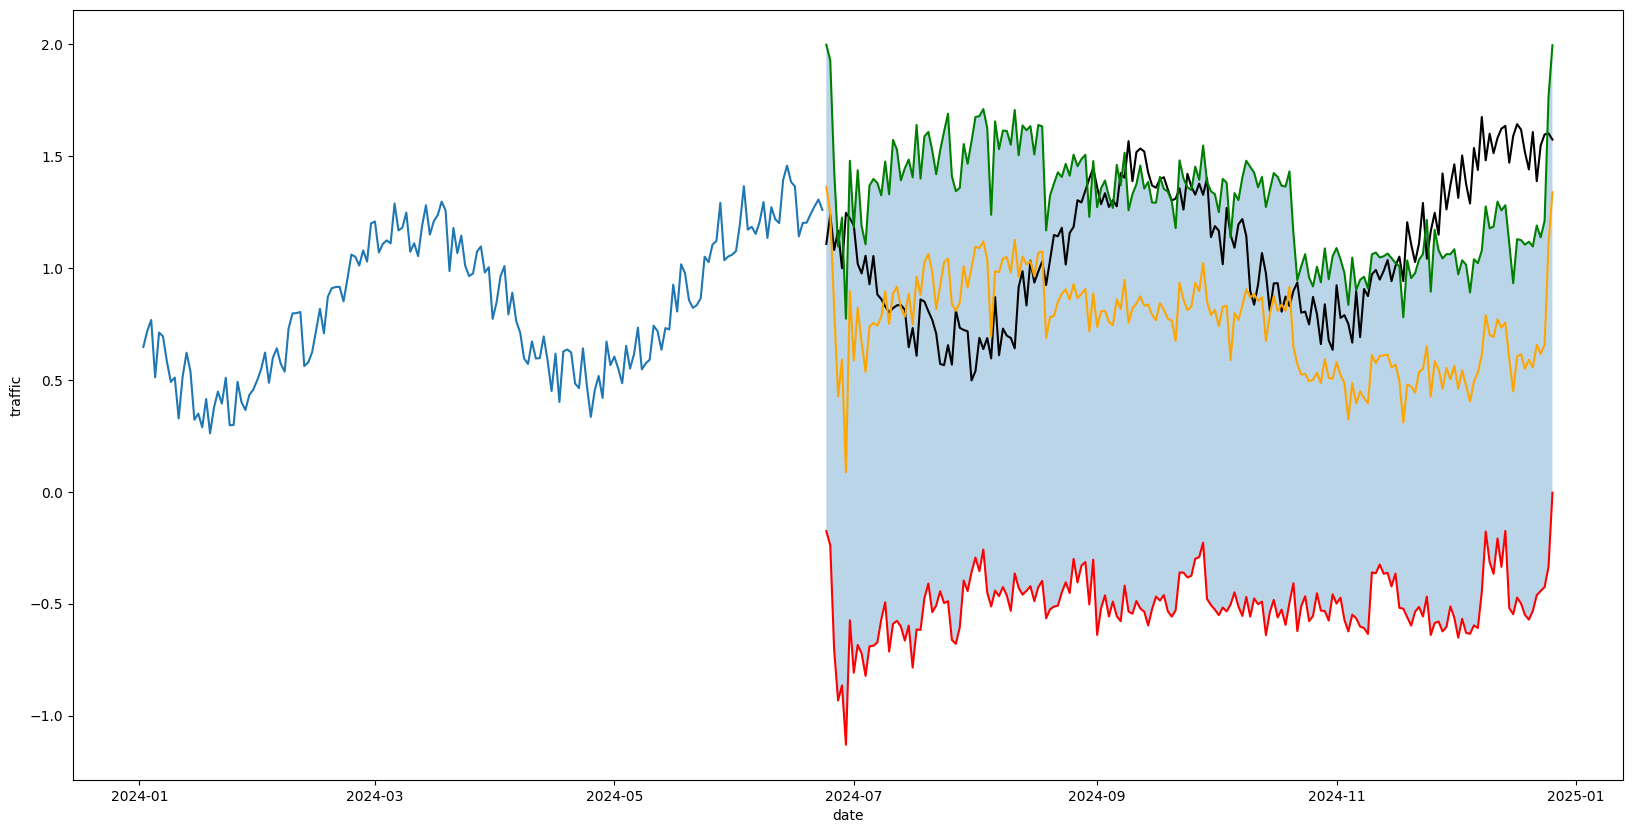

In [25]:
for i in range(5):
    plt.figure(figsize=(20,10))
    sns.lineplot(x=test[test["Entity"]==i].iloc[:ENCODER_STEPS-1]["date"], y=test[test["Entity"]==i].iloc[:ENCODER_STEPS-1]["traffic"])
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].labels, color="black")
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p10, color="red")
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p50, color="orange")
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p90, color="green")

    plt.fill_between(out_df[out_df["identifier"]==i].index, out_df[out_df["identifier"]==i].p10, out_df[out_df["identifier"]==i].p90, alpha=0.3)

    plt.show()

In [26]:
raw_data = pd.read_csv('./outputs/data/volatility/formatted_omi_vol.csv', index_col=0)
raw_data["date"] = pd.to_datetime(raw_data["date"])

train = raw_data[raw_data['year'] < 2016]
valid = raw_data.loc[(raw_data['year'] >= 2016) & (raw_data['year'] < 2018)]
test = raw_data.loc[(raw_data['year'] >= 2018) & (raw_data.index <= '2019-06-28')]

FileNotFoundError: [Errno 2] No such file or directory: './outputs/data/volatility/formatted_omi_vol.csv'

In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
real_columns = ['log_vol', 'open_to_close', 'days_from_start']
categorical_columns = ['Symbol', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'Region']

real_scalers, categorical_scalers = fit_preprocessing(train, real_columns, categorical_columns)

train = transform_inputs(train, real_scalers, categorical_scalers, real_columns, categorical_columns)
valid = transform_inputs(valid, real_scalers, categorical_scalers, real_columns, categorical_columns)
test = transform_inputs(test, real_scalers, categorical_scalers, real_columns, categorical_columns)

In [ ]:
# Global variables

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_EPOCHS = 12
DROPOUT = 0.3
LEARNING_RATE = 0.001
ENCODER_STEPS = 252
LOOKAHEAD = 5
DECODER_STEPS = ENCODER_STEPS + LOOKAHEAD
HIDDEN_LAYER_SIZE = 160
EMBEDDING_DIMENSION = 8
NUM_LSTM_LAYERS = 1
NUM_ATTENTION_HEADS = 1
QUANTILES = [0.1, 0.5, 0.9]


# Dataset variables
input_columns = ["log_vol", "open_to_close", "days_from_start", "day_of_week", "day_of_month", "week_of_year", "month", "Region", "Symbol"]
target_column = "log_vol"
entity_column = "Symbol"
time_column = "date"
col_to_idx = {col: idx for idx, col in enumerate(input_columns)}

In [ ]:
params = {
    "quantiles": QUANTILES,
    "batch_size": BATCH_SIZE,
    "dropout": DROPOUT,
    "device": DEVICE,
    "hidden_layer_size": HIDDEN_LAYER_SIZE,
    "num_lstm_layers": NUM_LSTM_LAYERS,
    "embedding_dim": EMBEDDING_DIMENSION,
    "encoder_steps": ENCODER_STEPS,
    "num_attention_heads": NUM_ATTENTION_HEADS,
    "col_to_idx": col_to_idx,
    "static_covariates": ["Region", "Symbol"],
    "time_dependent_categorical": ["day_of_week", "day_of_month", "week_of_year", "month"],
    "time_dependent_continuous": ['log_vol', 'days_from_start', "open_to_close",],
    "category_counts": {"day_of_week": 7, "day_of_month": 31, "week_of_year": 53, "month": 12, "Region": 4, "Symbol": 31},
    "known_time_dependent": ["day_of_week", "day_of_month", "week_of_year", "month", "days_from_start"],
    "observed_time_dependent": ["log_vol", "open_to_close"]
}

In [ ]:
training_data = TFT_Dataset(train, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
validation_data = TFT_Dataset(valid, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)
testing_data = TFT_Dataset(test, entity_column, time_column, target_column, input_columns, ENCODER_STEPS, DECODER_STEPS)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
valid_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

In [ ]:
model = TemporalFusionTransformer(params)
model.to(DEVICE)

In [ ]:
criterion = QuantileLoss(QUANTILES)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print_every_k = 250
losses = []

for epoch in range(NUM_EPOCHS):
    t0 = time.time()
    print(f"===== Epoch {epoch+1} =========")
    epoch_loss = 0.0
    running_loss = 0.0

    for i, batch in enumerate(train_dataloader):
        labels = batch['outputs'][:,:,0].flatten().float().to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        outputs, attention_weights = model(batch)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        epoch_loss += loss.item()

        if (i+1) % print_every_k == 0:
            print(f"Mini-batch {i+1} average loss: {round(running_loss / print_every_k, 5)}")
            running_loss = 0.0

    t1 = time.time()
    print(f"\nEpoch trained for {round(t1-t0, 2)} seconds")
    print("\nEpoch loss:", round(epoch_loss / (i+1), 5), "\n")
    losses.append(epoch_loss / (i+1))

In [ ]:
plt.plot(losses)

In [ ]:
from google.colab import files
torch.save(model.state_dict(), 'checkpoint.pth')

# download checkpoint file
files.download('checkpoint.pth')

In [ ]:
files.download('checkpoint.pth')

In [ ]:
out_df = pd.DataFrame(columns=['p10', 'p50', 'p90', 'identifier'])

start_id = -1

for i, batch in enumerate(test_dataloader):

    outputs, attention_weights = model(batch)
    bs = batch["outputs"].shape[0]

    process_map = {f"p{int(q * 100)}": outputs.reshape(bs, 5, 3)[:, :, i].cpu().detach().numpy()[::5,:].reshape(-1)[:bs] for i, q in enumerate(QUANTILES)}

    tmp = pd.DataFrame(data=process_map, index=pd.to_datetime(batch['time'][:, ENCODER_STEPS - 1, 0]))
    tmp["labels"] = batch["outputs"].reshape(-1)[::5]
    tmp["identifier"] = batch['identifier'][:, 0, 0]

    out_df = pd.concat([out_df, tmp])

    e = int(batch['identifier'][0, 0, 0].numpy())
    if batch['identifier'][0, 0, 0].numpy() != start_id:

        print("="*20)
        print(f"Plotting interpreation plots for a batch of entity {e}:")

        id_mask = batch['identifier'][:, 0, 0]==e

        #Plotting multi-head attention
        plt.figure(figsize=(15,10))
        sns.lineplot(x=pd.to_datetime(batch["time"][0,:,0].numpy()),
                     y=batch["inputs"][0,:,0].numpy(), color="blue")
        ax2 = plt.twinx()

        attn = attention_weights['multihead_attention'][0].cpu().detach().numpy().mean(axis=0)
        sns.lineplot(x=pd.to_datetime(batch["time"][0,:,0].numpy()),
                     y=attn/np.linalg.norm(attn),
                     ax=ax2, color="orange")
        plt.show()

        past_inputs = ["day_of_week", "day_of_month", "week_of_year", "month", 'log_vol', 'days_from_start', "open_to_close"]
        future_inputs = ["day_of_week", "day_of_month", "week_of_year", "month", "days_from_start"]

        # Plotting past weights
        plt.figure(figsize=(15,4))
        sns.barplot(x=past_inputs,
                    y=attention_weights['past_weights'][id_mask,:,:].mean(dim=(0,1)).cpu().detach().numpy(),
                    palette="crest")
        plt.show()

        # Plotting future weights
        plt.figure(figsize=(15,4))
        sns.barplot(x=future_inputs,
                    y=attention_weights['future_weights'][id_mask,:,:].mean(dim=(0,1)).cpu().detach().numpy(),
                    palette="crest")
        plt.show()
        start_id = e
        print()

In [ ]:
for i in test.Symbol.unique():
    plt.figure(figsize=(20,10))
    sns.lineplot(x=test[test["Symbol"]==i].iloc[:ENCODER_STEPS-1]["date"], y=test[test["Symbol"]==i].iloc[:ENCODER_STEPS-1]["log_vol"])
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].labels, color="black")
    #sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p10, color="red")
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p50, color="orange")
    #sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p90, color="green")

    plt.fill_between(out_df[out_df["identifier"]==i].index, out_df[out_df["identifier"]==i].p10, out_df[out_df["identifier"]==i].p90, alpha=0.3)

    plt.show()

In [ ]:
for i in test.Symbol.unique():
    plt.figure(figsize=(20,10))
    sns.lineplot(x=test[test["Symbol"]==i].iloc[:ENCODER_STEPS-1]["date"], y=test[test["Symbol"]==i].iloc[:ENCODER_STEPS-1]["log_vol"])
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].labels, color="black")
    #sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p10, color="red")
    sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p50, color="orange")
    #sns.lineplot(x=out_df[out_df["identifier"]==i].index, y=out_df[out_df["identifier"]==i].p90, color="green")

    plt.fill_between(out_df[out_df["identifier"]==i].index, out_df[out_df["identifier"]==i].p10, out_df[out_df["identifier"]==i].p90, alpha=0.3)

    plt.show()
